In [1]:
"""
NOVICA Customer Review Analysis with BERT
==========================================
Sentiment Analysis using BERT & Topic Modeling
"""

import pandas as pd
import numpy as np
import json
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Install required libraries
!pip install transformers torch vaderSentiment

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# BERT for Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab', quiet=True)

# ============================================================================
# SECTION 1: DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_prepare_data(filepath):
    """Load Excel data and extract reviews into a structured format."""
    df = pd.read_excel(filepath)
    print(f"Loaded {len(df)} products")
    print(f"Columns: {df.columns.tolist()}")

    reviews_list = []
    for idx, row in df.iterrows():
        if pd.notna(row.get('top_us_reviews_json')):
            try:
                reviews = json.loads(row['top_us_reviews_json'])
                for review in reviews:
                    reviews_list.append({
                        'sku': row.get('NOVICA SKU'),
                        'asin': row.get('ASIN'),
                        'product_title': row.get('Title'),
                        'classification': row.get('Classification'),
                        'classification_mapping': row.get('Classification Mapping'),
                        'price': row.get('price_value'),
                        'product_rating': row.get('rating_value'),
                        'product_review_count': row.get('ratings_count'),
                        'sales_365': row.get('Sales Last 365 Days'),
                        'review_text': review.get('review_text', ''),
                        'review_star': review.get('review_star_value'),
                        'review_author': review.get('review_author'),
                        'review_date': review.get('review_date_location'),
                        'verified_purchase': review.get('verified_purchase'),
                        'customers_say_summary': row.get('customers_say_summary')
                    })
            except (json.JSONDecodeError, TypeError):
                continue

    reviews_df = pd.DataFrame(reviews_list)
    print(f"\nExtracted {len(reviews_df)} individual reviews")
    return df, reviews_df


def clean_text(text):
    """Clean and preprocess review text."""
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = re.sub(r'\s*Read more\s*$', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def preprocess_for_nlp(text, lemmatizer, stop_words):
    """Tokenize, remove stopwords, and lemmatize text."""
    if not text:
        return []
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s']", ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 2]
    return tokens


# ============================================================================
# SECTION 2: BERT SENTIMENT ANALYSIS
# ============================================================================

class BERTSentimentAnalyzer:
    """BERT-based sentiment analysis for reviews."""

    def __init__(self, model_name='nlptown/bert-base-multilingual-uncased-sentiment'):
        """
        Initialize BERT model.

        Model options:
        - 'nlptown/bert-base-multilingual-uncased-sentiment' (1-5 star prediction)
        - 'cardiffnlp/twitter-roberta-base-sentiment-latest' (neg/neu/pos)
        - 'distilbert-base-uncased-finetuned-sst-2-english' (pos/neg only)
        """
        print(f"Loading BERT model: {model_name}")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        self.model_name = model_name

    def analyze_single(self, text, max_length=512):
        """Analyze sentiment of a single text using BERT."""
        if not text or len(text.strip()) == 0:
            return {
                'bert_score': 0.0,
                'bert_confidence': 0.0,
                'bert_label': 'Neutral',
                'bert_probabilities': [0.0] * 5
            }

        # Truncate text if too long
        text = text[:max_length * 4]  # Rough character limit before tokenization

        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding=True
        ).to(self.device)

        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = softmax(outputs.logits, dim=1).cpu().numpy()[0]

        # For nlptown model (5 classes: 1-5 stars)
        if 'nlptown' in self.model_name:
            # Predicted star rating (1-5)
            predicted_stars = np.argmax(probabilities) + 1
            confidence = float(np.max(probabilities))

            # Convert to compound score (-1 to 1) for compatibility
            # 1 star = -1, 3 stars = 0, 5 stars = 1
            compound_score = (predicted_stars - 3) / 2

            # Sentiment label
            if predicted_stars >= 4:
                label = 'Positive'
            elif predicted_stars <= 2:
                label = 'Negative'
            else:
                label = 'Neutral'

            return {
                'bert_score': compound_score,
                'bert_predicted_stars': predicted_stars,
                'bert_confidence': confidence,
                'bert_label': label,
                'bert_prob_1star': float(probabilities[0]),
                'bert_prob_2star': float(probabilities[1]),
                'bert_prob_3star': float(probabilities[2]),
                'bert_prob_4star': float(probabilities[3]),
                'bert_prob_5star': float(probabilities[4])
            }

        # For other 3-class models (negative, neutral, positive)
        else:
            labels = ['Negative', 'Neutral', 'Positive']
            predicted_idx = np.argmax(probabilities)
            label = labels[predicted_idx]
            confidence = float(np.max(probabilities))

            # Compound score: weight by probabilities
            compound_score = probabilities[2] - probabilities[0]

            return {
                'bert_score': float(compound_score),
                'bert_confidence': confidence,
                'bert_label': label,
                'bert_prob_negative': float(probabilities[0]),
                'bert_prob_neutral': float(probabilities[1]),
                'bert_prob_positive': float(probabilities[2])
            }

    def analyze_batch(self, texts, batch_size=16, max_length=512):
        """Analyze sentiment of multiple texts in batches."""
        results = []
        total = len(texts)

        for i in range(0, total, batch_size):
            batch = texts[i:i+batch_size]

            # Progress indicator
            if i % (batch_size * 10) == 0:
                print(f"  Processing {i}/{total} reviews ({100*i/total:.1f}%)")

            for text in batch:
                result = self.analyze_single(text, max_length)
                results.append(result)

        print(f"  Completed {total}/{total} reviews (100%)")
        return results


def run_bert_sentiment_analysis(reviews_df, model_name='nlptown/bert-base-multilingual-uncased-sentiment'):
    """Run BERT sentiment analysis on all reviews."""

    # Initialize BERT analyzer
    analyzer = BERTSentimentAnalyzer(model_name=model_name)

    # Clean text
    reviews_df['clean_text'] = reviews_df['review_text'].apply(clean_text)

    # Run BERT analysis
    print("\nRunning BERT sentiment analysis...")
    texts = reviews_df['clean_text'].tolist()
    sentiment_results = analyzer.analyze_batch(texts, batch_size=16)

    # Convert results to DataFrame and merge
    sentiment_df = pd.DataFrame(sentiment_results)
    reviews_df = pd.concat([reviews_df.reset_index(drop=True), sentiment_df], axis=1)

    # Create unified sentiment label column
    reviews_df['sentiment_label'] = reviews_df['bert_label']

    return reviews_df, analyzer


# ============================================================================
# SECTION 3: TOPIC MODELING (Same as before)
# ============================================================================

class TopicModeler:
    """Advanced topic modeling with multiple methods."""

    def __init__(self, n_topics=8):
        self.n_topics = n_topics
        self.lda_model = None
        self.nmf_model = None
        self.vectorizer = None
        self.tfidf_vectorizer = None

    def prepare_corpus(self, texts, method='count'):
        """Prepare document-term matrix."""
        custom_stops = set(stopwords.words('english'))
        custom_stops.update(['product', 'item', 'bought', 'buy', 'purchase',
                           'amazon', 'ordered', 'order', 'shipping', 'shipped',
                           'arrived', 'received', 'would', 'could', 'also',
                           'one', 'two', 'get', 'got', 'really', 'very',
                           'much', 'well', 'like', 'just', 'even', 'made'])

        if method == 'count':
            self.vectorizer = CountVectorizer(
                max_df=0.95, min_df=2, max_features=1000,
                stop_words=list(custom_stops), ngram_range=(1, 2)
            )
            return self.vectorizer.fit_transform(texts)
        else:
            self.tfidf_vectorizer = TfidfVectorizer(
                max_df=0.95, min_df=2, max_features=1000,
                stop_words=list(custom_stops), ngram_range=(1, 2)
            )
            return self.tfidf_vectorizer.fit_transform(texts)

    def fit_lda(self, texts):
        """Fit LDA topic model."""
        print(f"Fitting LDA with {self.n_topics} topics...")
        dtm = self.prepare_corpus(texts, method='count')
        self.lda_model = LatentDirichletAllocation(
            n_components=self.n_topics, max_iter=20,
            learning_method='online', random_state=42, n_jobs=-1
        )
        doc_topics = self.lda_model.fit_transform(dtm)
        return doc_topics, self.vectorizer.get_feature_names_out()

    def fit_nmf(self, texts):
        """Fit NMF topic model."""
        print(f"Fitting NMF with {self.n_topics} topics...")
        tfidf = self.prepare_corpus(texts, method='tfidf')
        self.nmf_model = NMF(n_components=self.n_topics, random_state=42, max_iter=400)
        doc_topics = self.nmf_model.fit_transform(tfidf)
        return doc_topics, self.tfidf_vectorizer.get_feature_names_out()

    def get_topic_words(self, model, feature_names, n_words=15):
        """Extract top words for each topic."""
        topics = {}
        for idx, topic in enumerate(model.components_):
            top_word_indices = topic.argsort()[:-n_words-1:-1]
            top_words = [feature_names[i] for i in top_word_indices]
            topics[f"Topic_{idx}"] = top_words
        return topics

    def assign_dominant_topic(self, doc_topics):
        """Assign dominant topic to each document."""
        return np.argmax(doc_topics, axis=1)


def run_topic_modeling(reviews_df, n_topics=8):
    """Run topic modeling and add results to dataframe."""
    valid_mask = reviews_df['clean_text'].str.len() > 10
    valid_texts = reviews_df.loc[valid_mask, 'clean_text'].tolist()

    modeler = TopicModeler(n_topics=n_topics)

    lda_doc_topics, lda_features = modeler.fit_lda(valid_texts)
    lda_topics = modeler.get_topic_words(modeler.lda_model, lda_features)

    nmf_doc_topics, nmf_features = modeler.fit_nmf(valid_texts)
    nmf_topics = modeler.get_topic_words(modeler.nmf_model, nmf_features)

    reviews_df.loc[valid_mask, 'lda_topic'] = modeler.assign_dominant_topic(lda_doc_topics)
    reviews_df.loc[valid_mask, 'nmf_topic'] = modeler.assign_dominant_topic(nmf_doc_topics)

    for i in range(n_topics):
        reviews_df.loc[valid_mask, f'lda_topic_{i}_prob'] = lda_doc_topics[:, i]
        reviews_df.loc[valid_mask, f'nmf_topic_{i}_prob'] = nmf_doc_topics[:, i]

    return reviews_df, lda_topics, nmf_topics, modeler


# ============================================================================
# SECTION 4: ANALYSIS FUNCTIONS
# ============================================================================

def get_top_words(texts, n=20):
    """Get most frequent words from a series of texts."""
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    stop_words.update(['product', 'item', 'bought', 'buy', 'purchase', 'would',
                       'could', 'also', 'one', 'get', 'got', 'really', 'very'])
    all_words = []
    for text in texts:
        if isinstance(text, str):
            tokens = preprocess_for_nlp(text, lemmatizer, stop_words)
            all_words.extend(tokens)
    return Counter(all_words).most_common(n)


def analyze_by_classification(reviews_df, classification_col='classification'):
    """Deep dive analysis for each product classification."""
    results = {}
    for classification in reviews_df[classification_col].dropna().unique():
        cat_df = reviews_df[reviews_df[classification_col] == classification]
        if len(cat_df) < 5:
            continue
        results[classification] = {
            'n_reviews': len(cat_df),
            'n_products': cat_df['sku'].nunique(),
            'avg_star_rating': cat_df['review_star'].mean(),
            'rating_distribution': cat_df['review_star'].value_counts().to_dict(),
            'avg_bert_score': cat_df['bert_score'].mean(),
            'sentiment_distribution': cat_df['sentiment_label'].value_counts().to_dict(),
            'avg_bert_confidence': cat_df['bert_confidence'].mean(),
            'topic_distribution': cat_df['lda_topic'].value_counts().to_dict() if 'lda_topic' in cat_df.columns else {},
            'avg_sales': cat_df['sales_365'].mean() if 'sales_365' in cat_df.columns else None,
            'top_words': get_top_words(cat_df['clean_text'], n=20)
        }
    return results


def analyze_high_vs_low_ratings(reviews_df):
    """Compare language and sentiment between high and low rated reviews."""
    high_rated = reviews_df[reviews_df['review_star'] >= 4]
    low_rated = reviews_df[reviews_df['review_star'] <= 2]

    return {
        'high_rated': {
            'count': len(high_rated),
            'avg_bert_score': high_rated['bert_score'].mean(),
            'avg_bert_confidence': high_rated['bert_confidence'].mean(),
            'top_words': get_top_words(high_rated['clean_text'], n=30)
        },
        'low_rated': {
            'count': len(low_rated),
            'avg_bert_score': low_rated['bert_score'].mean(),
            'avg_bert_confidence': low_rated['bert_confidence'].mean(),
            'top_words': get_top_words(low_rated['clean_text'], n=30)
        }
    }


def analyze_correlations(reviews_df):
    """Analyze correlations between review characteristics and sales."""
    product_metrics = reviews_df.groupby('sku').agg({
        'bert_score': 'mean',
        'review_star': 'mean',
        'bert_confidence': 'mean',
        'sales_365': 'first',
        'product_review_count': 'first',
        'price': 'first',
        'classification': 'first'
    }).reset_index()

    product_metrics.columns = ['sku', 'avg_bert_sentiment', 'avg_rating',
                               'avg_confidence', 'sales', 'review_count',
                               'price', 'classification']

    numeric_cols = ['avg_bert_sentiment', 'avg_rating', 'avg_confidence',
                    'sales', 'review_count', 'price']
    correlations = product_metrics[numeric_cols].corr()

    print("\n" + "="*70)
    print("CORRELATION MATRIX (BERT-based)")
    print("="*70)
    print(correlations.round(3))

    return product_metrics, correlations


# ============================================================================
# SECTION 5: VISUALIZATION
# ============================================================================

def create_visualizations(reviews_df, lda_topics, nmf_topics, output_dir='./output'):
    """Generate comprehensive visualizations."""
    import os
    os.makedirs(output_dir, exist_ok=True)
    plt.style.use('seaborn-v0_8-whitegrid')

    # 1. BERT Sentiment Distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    reviews_df['sentiment_label'].value_counts().plot(
        kind='bar', ax=axes[0], color=['green', 'gray', 'red'])
    axes[0].set_title('BERT Sentiment Distribution')
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Count')

    axes[1].hist(reviews_df['bert_score'].dropna(), bins=50, color='steelblue', edgecolor='black')
    axes[1].set_title('BERT Sentiment Score Distribution')
    axes[1].set_xlabel('BERT Score (-1 to 1)')
    axes[1].axvline(x=0, color='red', linestyle='--')

    reviews_df.groupby('review_star')['bert_score'].mean().plot(kind='bar', ax=axes[2], color='coral')
    axes[2].set_title('Average BERT Score by Star Rating')
    axes[2].set_xlabel('Star Rating')
    axes[2].set_ylabel('Avg BERT Score')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/bert_sentiment_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. BERT Confidence Distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(reviews_df['bert_confidence'].dropna(), bins=50, color='teal', edgecolor='black')
    ax.set_title('BERT Model Confidence Distribution')
    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/bert_confidence.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Star Rating vs BERT Predicted Stars (if using nlptown model)
    if 'bert_predicted_stars' in reviews_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        confusion = pd.crosstab(reviews_df['review_star'], reviews_df['bert_predicted_stars'])
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title('Actual Stars vs BERT Predicted Stars')
        ax.set_xlabel('BERT Predicted Stars')
        ax.set_ylabel('Actual Star Rating')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/bert_star_confusion.png', dpi=300, bbox_inches='tight')
        plt.close()

    # 4. Topic Distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    if 'lda_topic' in reviews_df.columns:
        reviews_df['lda_topic'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='teal')
        axes[0].set_title('LDA Topic Distribution')
    if 'nmf_topic' in reviews_df.columns:
        reviews_df['nmf_topic'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='purple')
        axes[1].set_title('NMF Topic Distribution')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/topic_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 5. Sentiment by Classification
    if 'classification' in reviews_df.columns:
        fig, ax = plt.subplots(figsize=(12, 6))
        class_sentiment = reviews_df.groupby('classification')['bert_score'].agg(['mean', 'count'])
        class_sentiment = class_sentiment[class_sentiment['count'] >= 5].sort_values('mean', ascending=True)
        colors = ['red' if x < 0 else 'green' for x in class_sentiment['mean']]
        class_sentiment['mean'].plot(kind='barh', ax=ax, color=colors)
        ax.set_title('Average BERT Sentiment by Product Classification')
        ax.set_xlabel('Average BERT Score')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/bert_sentiment_by_classification.png', dpi=300, bbox_inches='tight')
        plt.close()

    print(f"Visualizations saved to {output_dir}/")


def print_topic_summary(lda_topics, nmf_topics):
    """Print formatted topic summaries."""
    print("\n" + "="*70)
    print("LDA TOPIC MODEL RESULTS")
    print("="*70)
    for topic, words in lda_topics.items():
        print(f"\n{topic}:")
        print(f"  Keywords: {', '.join(words[:10])}")

    print("\n" + "="*70)
    print("NMF TOPIC MODEL RESULTS")
    print("="*70)
    for topic, words in nmf_topics.items():
        print(f"\n{topic}:")
        print(f"  Keywords: {', '.join(words[:10])}")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main(filepath, n_topics=8, bert_model='nlptown/bert-base-multilingual-uncased-sentiment'):
    """Main execution function with BERT."""

    print("="*70)
    print("NOVICA CUSTOMER REVIEW ANALYSIS WITH BERT")
    print("Sentiment Analysis & Topic Modeling")
    print("="*70)

    # Step 1: Load data
    print("\n[1/6] Loading and preparing data...")
    products_df, reviews_df = load_and_prepare_data(filepath)

    # Step 2: BERT sentiment analysis
    print("\n[2/6] Running BERT sentiment analysis...")
    reviews_df, bert_analyzer = run_bert_sentiment_analysis(reviews_df, model_name=bert_model)

    # Step 3: Topic modeling
    print("\n[3/6] Running topic modeling...")
    reviews_df, lda_topics, nmf_topics, modeler = run_topic_modeling(reviews_df, n_topics=n_topics)

    # Step 4: Print summaries
    print("\n[4/6] Topic model results...")
    print_topic_summary(lda_topics, nmf_topics)

    # Step 5: Category analysis
    print("\n[5/6] Analyzing by classification...")
    category_analysis = analyze_by_classification(reviews_df)

    print("\n" + "="*70)
    print("ANALYSIS BY PRODUCT CLASSIFICATION (BERT)")
    print("="*70)
    for cat, metrics in sorted(category_analysis.items(), key=lambda x: x[1]['n_reviews'], reverse=True):
        print(f"\n{cat}:")
        print(f"  Reviews: {metrics['n_reviews']}, Products: {metrics['n_products']}")
        print(f"  Avg Rating: {metrics['avg_star_rating']:.2f}")
        print(f"  Avg BERT Score: {metrics['avg_bert_score']:.3f}")
        print(f"  BERT Confidence: {metrics['avg_bert_confidence']:.3f}")

    # Step 6: High vs Low comparison
    print("\n[6/6] Comparing high vs low rated reviews...")
    rating_comparison = analyze_high_vs_low_ratings(reviews_df)

    print("\n" + "="*70)
    print("HIGH-RATED vs LOW-RATED (BERT Analysis)")
    print("="*70)
    print(f"\nHigh-Rated ({rating_comparison['high_rated']['count']} reviews):")
    print(f"  Avg BERT Score: {rating_comparison['high_rated']['avg_bert_score']:.3f}")
    print(f"  Avg Confidence: {rating_comparison['high_rated']['avg_bert_confidence']:.3f}")

    print(f"\nLow-Rated ({rating_comparison['low_rated']['count']} reviews):")
    print(f"  Avg BERT Score: {rating_comparison['low_rated']['avg_bert_score']:.3f}")
    print(f"  Avg Confidence: {rating_comparison['low_rated']['avg_bert_confidence']:.3f}")

    # Correlations
    print("\n[BONUS] Correlation analysis...")
    product_metrics, correlations = analyze_correlations(reviews_df)

    # Visualizations
    print("\n[GENERATING VISUALIZATIONS]...")
    create_visualizations(reviews_df, lda_topics, nmf_topics)

    # Save results
    print("\n[SAVING RESULTS]...")
    reviews_df.to_csv('reviews_with_bert_sentiment.csv', index=False)
    product_metrics.to_csv('product_level_metrics_bert.csv', index=False)

    print("\n" + "="*70)
    print("BERT ANALYSIS COMPLETE!")
    print("="*70)
    print("\nOutput files created:")
    print("  - reviews_with_bert_sentiment.csv")
    print("  - product_level_metrics_bert.csv")
    print("  - output/*.png (visualizations)")

    return reviews_df, products_df, lda_topics, nmf_topics, category_analysis


# Run the analysis
if __name__ == "__main__":
    filepath = "/content/scraped_amazon.xlsx"

    # Choose BERT model:
    # - 'nlptown/bert-base-multilingual-uncased-sentiment' (predicts 1-5 stars)
    # - 'cardiffnlp/twitter-roberta-base-sentiment-latest' (neg/neu/pos)

    reviews_df, products_df, lda_topics, nmf_topics, category_analysis = main(
        filepath,
        n_topics=8,
        bert_model='nlptown/bert-base-multilingual-uncased-sentiment'
    )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00
NOVICA CUSTOMER REVIEW ANALYSIS WITH BERT
Sentiment Analysis & Topic Modeling

[1/6] Loading and preparing data...
Loaded 10009 products
Columns: ['NOVICA SKU', 'ASIN', 'Title', 'Classification', 'Classification Mapping', 'Title on Amazon', 'price_value', 'availability', 'rating_value', 'ratings_count', 'customers_say_summary', 'customers_say_tags_json', 'top_us_reviews_json', 'source_url', 'Total Quantity', 'DC Quantity', 'Sales Last 365 Days']

Extracted 17862 individual reviews

[2/6] Running BERT sentiment analysis...
Loading BERT model: nlptown/bert-base-multilingual-uncased-sentiment
Using device: cpu


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]


Running BERT sentiment analysis...
  Processing 0/17862 reviews (0.0%)
  Processing 160/17862 reviews (0.9%)
  Processing 320/17862 reviews (1.8%)
  Processing 480/17862 reviews (2.7%)
  Processing 640/17862 reviews (3.6%)
  Processing 800/17862 reviews (4.5%)
  Processing 960/17862 reviews (5.4%)
  Processing 1120/17862 reviews (6.3%)
  Processing 1280/17862 reviews (7.2%)
  Processing 1440/17862 reviews (8.1%)
  Processing 1600/17862 reviews (9.0%)
  Processing 1760/17862 reviews (9.9%)
  Processing 1920/17862 reviews (10.7%)
  Processing 2080/17862 reviews (11.6%)
  Processing 2240/17862 reviews (12.5%)
  Processing 2400/17862 reviews (13.4%)
  Processing 2560/17862 reviews (14.3%)
  Processing 2720/17862 reviews (15.2%)
  Processing 2880/17862 reviews (16.1%)
  Processing 3040/17862 reviews (17.0%)
  Processing 3200/17862 reviews (17.9%)
  Processing 3360/17862 reviews (18.8%)
  Processing 3520/17862 reviews (19.7%)
  Processing 3680/17862 reviews (20.6%)
  Processing 3840/17862 r

In [19]:
reviews_df = pd.read_csv('reviews_with_bert_sentiment.csv')

Loaded BERT-analyzed data
✓ Using BERT sentiment analysis
✓ Dashboard saved: novica_executive_dashboard_bert.png


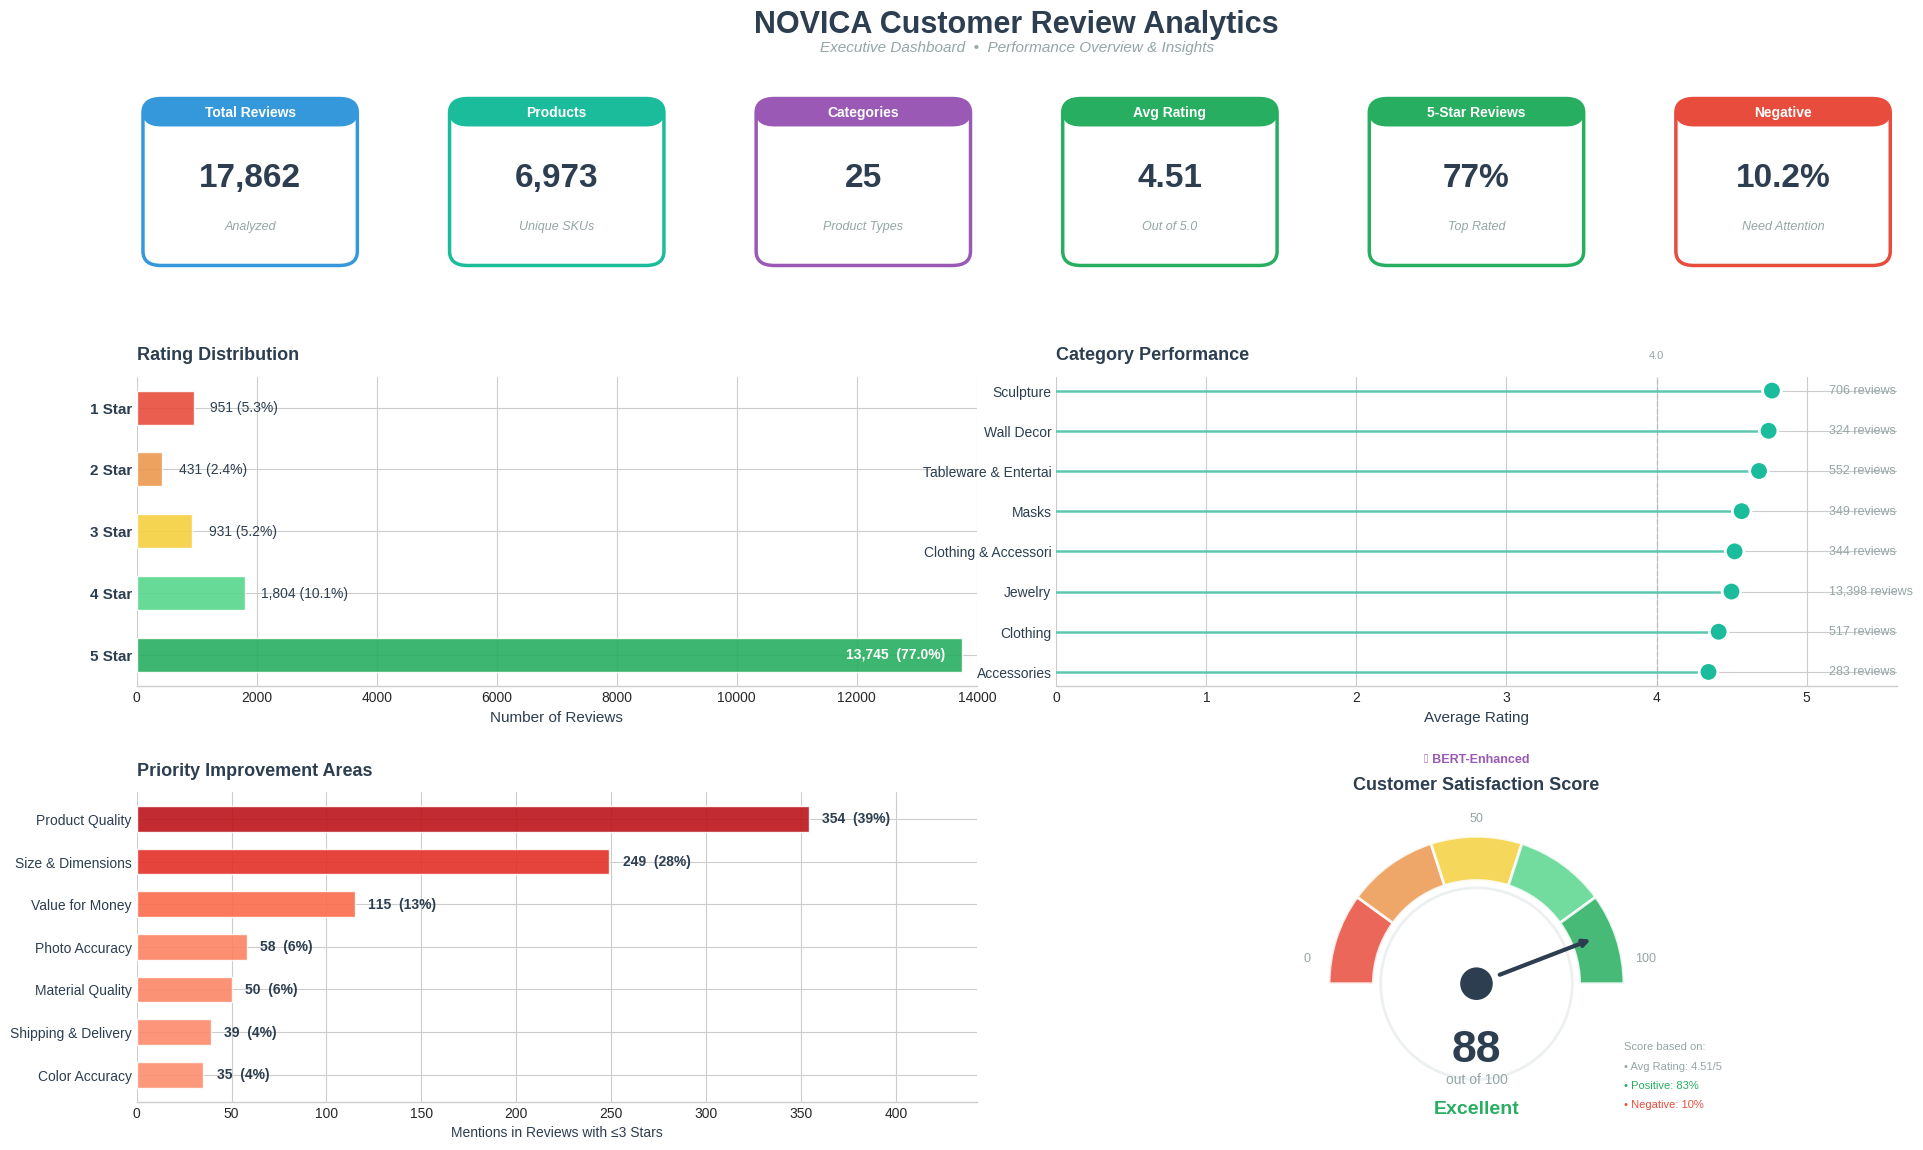

In [24]:
"""
NOVICA Executive Dashboard (BERT Version)
==========================================
Clean, well-designed dashboard using BERT sentiment analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch, Circle, Wedge
import seaborn as sns
import re

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Color palette
COLORS = {
    'primary': '#2C3E50',
    'secondary': '#3498DB',
    'positive': '#27AE60',
    'negative': '#E74C3C',
    'warning': '#F39C12',
    'neutral': '#95A5A6',
    'background': '#F8F9FA',
    'accent1': '#9B59B6',
    'accent2': '#1ABC9C',
    'accent': '#9B59B6',
    'muted': '#95A5A6',
    'high': '#F39C12',      # Using 'warning' color for 'high' impact
    'critical': '#E74C3C',  # Using 'negative' color for 'critical' issues
    'medium': '#3498DB',    # Using 'secondary' color for 'medium' importance
}


def create_executive_dashboard(reviews_df, figsize=(20, 12), save_path=None):
    """Create a clean, professional executive dashboard using BERT sentiment."""
    reviews_df = reviews_df.copy()

    # Use BERT sentiment if available, otherwise fall back to star-based
    if 'bert_label' in reviews_df.columns:
        reviews_df['sentiment_label'] = reviews_df['bert_label']
        print("✓ Using BERT sentiment analysis")
    elif 'sentiment_label' not in reviews_df.columns:
        reviews_df['sentiment_label'] = reviews_df['review_star'].apply(
            lambda x: 'Positive' if x >= 4 else ('Negative' if x <= 2 else 'Neutral')
        )
        print("⚠ BERT sentiment not found, using star-based sentiment")

    total_reviews = len(reviews_df)
    total_products = reviews_df['sku'].nunique()
    avg_rating = reviews_df['review_star'].mean()
    positive_pct = (reviews_df['sentiment_label'] == 'Positive').sum() / total_reviews * 100
    negative_pct = (reviews_df['sentiment_label'] == 'Negative').sum() / total_reviews * 100

    # Get BERT confidence if available
    avg_bert_confidence = reviews_df['bert_confidence'].mean() if 'bert_confidence' in reviews_df.columns else None

    improvement_areas = detect_improvement_areas(reviews_df)

    fig = plt.figure(figsize=figsize, facecolor='white')

    # Title with BERT indicator
    title_text = 'NOVICA Customer Review Analytics'
    if 'bert_score' in reviews_df.columns:
        title_text += ''

    fig.suptitle(title_text, fontsize=22, fontweight='bold', color=COLORS['primary'], y=0.97)
    fig.text(0.5, 0.935, 'Executive Dashboard  •  Performance Overview & Insights',
             fontsize=11, color=COLORS['neutral'], ha='center', style='italic')

    gs = gridspec.GridSpec(3, 6, height_ratios=[0.8, 1.4, 1.4],
                           hspace=0.4, wspace=0.35,
                           left=0.06, right=0.94, top=0.90, bottom=0.06)

    # ROW 1: KPI Cards
    five_star_pct = (reviews_df['review_star'] == 5).sum() / total_reviews * 100
    categories_count = reviews_df['classification'].nunique()

    ax_kpi1 = fig.add_subplot(gs[0, 0])
    create_kpi_card(ax_kpi1, 'Total Reviews', f'{total_reviews:,}', subtitle='Analyzed', color=COLORS['secondary'])

    ax_kpi2 = fig.add_subplot(gs[0, 1])
    create_kpi_card(ax_kpi2, 'Products', f'{total_products:,}', subtitle='Unique SKUs', color=COLORS['accent2'])

    ax_kpi3 = fig.add_subplot(gs[0, 2])
    create_kpi_card(ax_kpi3, 'Categories', f'{categories_count}', subtitle='Product Types', color=COLORS['accent1'])

    ax_kpi4 = fig.add_subplot(gs[0, 3])
    rating_color = COLORS['positive'] if avg_rating >= 4 else (COLORS['warning'] if avg_rating >= 3 else COLORS['negative'])
    create_kpi_card(ax_kpi4, 'Avg Rating', f'{avg_rating:.2f}', subtitle='Out of 5.0', color=rating_color)

    ax_kpi5 = fig.add_subplot(gs[0, 4])
    create_kpi_card(ax_kpi5, '5-Star Reviews', f'{five_star_pct:.0f}%', subtitle='Top Rated', color=COLORS['positive'])

    ax_kpi6 = fig.add_subplot(gs[0, 5])
    create_kpi_card(ax_kpi6, 'Negative', f'{negative_pct:.1f}%', subtitle='Need Attention', color=COLORS['negative'])

    # ROW 2: Main Charts
    ax_rating = fig.add_subplot(gs[1, 0:3])
    plot_rating_distribution(ax_rating, reviews_df)

    ax_sentiment = fig.add_subplot(gs[1, 3:6])
    plot_category_performance(ax_sentiment, reviews_df)

    # ROW 3: Improvement Areas & Satisfaction Gauge
    ax_improvement = fig.add_subplot(gs[2, 0:3])
    plot_improvement_areas(ax_improvement, improvement_areas)

    ax_gauge = fig.add_subplot(gs[2, 3:6])
    plot_satisfaction_gauge(ax_gauge, reviews_df)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Dashboard saved: {save_path}")

    plt.show()
    return fig


def create_kpi_card(ax, title, value, subtitle='', color='#3498DB'):
    """Create a clean, modern KPI card."""
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    bg = FancyBboxPatch((0.3, 0.3), 9.4, 9.4, boxstyle="round,pad=0.02,rounding_size=0.8",
                        facecolor='white', edgecolor=color, linewidth=2.5, transform=ax.transData)
    ax.add_patch(bg)

    accent = FancyBboxPatch((0.3, 8.2), 9.4, 1.5, boxstyle="round,pad=0.02,rounding_size=0.8",
                            facecolor=color, edgecolor=color, transform=ax.transData)
    ax.add_patch(accent)

    ax.text(5, 8.9, title, fontsize=10, ha='center', va='center', fontweight='bold', color='white')
    ax.text(5, 5.2, value, fontsize=24, ha='center', va='center', fontweight='bold', color=COLORS['primary'])
    if subtitle:
        ax.text(5, 2.5, subtitle, fontsize=9, ha='center', va='center', color=COLORS['neutral'], style='italic')


def plot_rating_distribution(ax, reviews_df):
    """Plot rating distribution with '1 Star', '2 Star', etc. labels."""
    rating_counts = reviews_df['review_star'].value_counts().sort_index(ascending=False)
    total = len(reviews_df)

    colors = {5: '#27AE60', 4: '#58D68D', 3: '#F4D03F', 2: '#EB984E', 1: '#E74C3C'}
    bar_colors = [colors.get(r, COLORS['neutral']) for r in rating_counts.index]

    bars = ax.barh(range(len(rating_counts)), rating_counts.values,
                   color=bar_colors, edgecolor='white', height=0.55, alpha=0.9)

    ax.set_yticks(range(len(rating_counts)))
    # Changed to "X Star" format
    ax.set_yticklabels([f'{int(r)} Star' for r in rating_counts.index],
                       fontsize=11, color=COLORS['primary'], fontweight='bold')

    for bar, (rating, count) in zip(bars, rating_counts.items()):
        pct = count / total * 100
        if pct > 15:
            ax.text(bar.get_width() - max(rating_counts) * 0.02, bar.get_y() + bar.get_height()/2,
                    f'{count:,}  ({pct:.1f}%)', va='center', ha='right', fontsize=10, fontweight='bold', color='white')
        else:
            ax.text(bar.get_width() + max(rating_counts) * 0.02, bar.get_y() + bar.get_height()/2,
                    f'{count:,} ({pct:.1f}%)', va='center', ha='left', fontsize=10, color=COLORS['primary'])

    ax.set_xlabel('Number of Reviews', fontsize=11, color=COLORS['primary'])
    ax.set_title('Rating Distribution', fontsize=13, fontweight='bold', color=COLORS['primary'], pad=12, loc='left')
    ax.set_xlim(0, 14000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False)


def plot_category_performance(ax, reviews_df):
    """Plot category performance as lollipop chart showing avg rating and review count."""
    top_categories = reviews_df['classification'].value_counts().head(8).index.tolist()

    data = []
    for cat in top_categories:
        cat_df = reviews_df[reviews_df['classification'] == cat]
        avg_rating = cat_df['review_star'].mean()
        review_count = len(cat_df)
        data.append({'category': cat[:20], 'avg_rating': avg_rating, 'reviews': review_count})

    df = pd.DataFrame(data).sort_values('avg_rating', ascending=True)

    y_pos = range(len(df))

    # All ratings are good (above 4), use teal/green gradient
    colors = [COLORS['accent2'] if r >= 4.5 else COLORS['accent2'] for r in df['avg_rating']]

    # Draw horizontal lines from 0 to the rating
    for i, (rating, color) in enumerate(zip(df['avg_rating'], colors)):
        ax.plot([0, rating], [i, i], color=color, linewidth=2, alpha=0.6)

    # Draw circles at the end
    ax.scatter(df['avg_rating'], y_pos, s=180, c=colors, edgecolors='white', linewidths=2, zorder=5)

    # Add rating values inside circles
    for i, rating in enumerate(df['avg_rating']):
        ax.text(rating, i, f'{rating:.1f}', ha='center', va='center', fontsize=7, fontweight='bold', color='white')

    # Add review count on the right side
    for i, reviews in enumerate(df['reviews']):
        ax.text(5.15, i, f'{reviews:,} reviews', va='center', ha='left', fontsize=9, color=COLORS['neutral'])

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['category'], fontsize=10, color=COLORS['primary'])
    ax.set_xlabel('Average Rating', fontsize=11, color=COLORS['primary'])
    ax.set_title('Category Performance', fontsize=13, fontweight='bold', color=COLORS['primary'], pad=12, loc='left')
    ax.set_xlim(0, 5.6)

    # Add vertical reference line at 4.0
    ax.axvline(x=4.0, color=COLORS['neutral'], linestyle='--', alpha=0.4, linewidth=1)
    ax.text(4.0, len(df) - 0.2, '4.0', fontsize=8, color=COLORS['neutral'], ha='center')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False)


def plot_reviews_over_time(ax, reviews_df):
    """Plot reviews over time as an area chart with trend line."""
    # Convert review_date to datetime
    reviews_df = reviews_df.copy()
    reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'], errors='coerce')
    reviews_df = reviews_df.dropna(subset=['review_date'])

    # Group by month
    reviews_df['month'] = reviews_df['review_date'].dt.to_period('M')
    monthly_data = reviews_df.groupby('month').agg(
        review_count=('review_star', 'count'),
        avg_rating=('review_star', 'mean')
    ).reset_index()
    monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

    # Only keep recent data if too many months (last 24 months)
    if len(monthly_data) > 24:
        monthly_data = monthly_data.tail(24)

    # Create area chart for review count
    ax.fill_between(monthly_data['month'], monthly_data['review_count'],
                    alpha=0.3, color=COLORS['secondary'])
    ax.plot(monthly_data['month'], monthly_data['review_count'],
            color=COLORS['secondary'], linewidth=2.5, marker='o', markersize=4)

    # Add trend line
    x_numeric = np.arange(len(monthly_data))
    z = np.polyfit(x_numeric, monthly_data['review_count'], 1)
    p = np.poly1d(z)
    trend_color = COLORS['positive'] if z[0] > 0 else COLORS['negative']
    ax.plot(monthly_data['month'], p(x_numeric), '--', color=trend_color,
            linewidth=2, alpha=0.7, label=f'Trend ({"↑" if z[0] > 0 else "↓"})')

    # Calculate stats for annotation
    total_reviews = monthly_data['review_count'].sum()
    avg_monthly = monthly_data['review_count'].mean()
    max_month = monthly_data.loc[monthly_data['review_count'].idxmax()]

    # Format x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)

    ax.set_xlabel('Month', fontsize=11, color=COLORS['primary'])
    ax.set_ylabel('Number of Reviews', fontsize=11, color=COLORS['primary'])
    ax.set_title('Reviews Over Time', fontsize=13, fontweight='bold',
                 color=COLORS['primary'], pad=12, loc='left')

    # Add stats annotation box
    stats_text = f'Avg: {avg_monthly:.0f}/mo\nPeak: {max_month["review_count"]:,.0f}'
    ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                      edgecolor=COLORS['neutral'], alpha=0.9))

    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax.set_ylim(bottom=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def detect_improvement_areas(reviews_df):
    """Detect improvement areas from negative reviews."""
    IMPROVEMENT_PATTERNS = {
        'Product Quality': [r'(broke|broken|crack|chip|defect|flimsy)', r'(cheap|poor|bad) quality', r'(poorly|badly) made'],
        'Size & Dimensions': [r'(too|very) (small|large|big)', r'(smaller|larger) than', r'wrong size', r'dimensions'],
        'Photo Accuracy': [r'(looks?|looked?) different', r'not (as|like) (pictured|shown)', r'(photo|picture).*(misleading|different)'],
        'Color Accuracy': [r'(color|colour).*(different|off|wrong)', r'not the (same|right) color'],
        'Packaging': [r'(poor|bad|no) packaging', r'packaging.*(damaged|poor)', r'(poorly|badly) packed'],
        'Shipping & Delivery': [r'(arrived|came) (damaged|broken)', r'shipping (damage|issue)', r'(slow|late) (shipping|delivery)'],
        'Product Description': [r'not (as|what) described', r'(description|listing).*(wrong|inaccurate)', r'misleading'],
        'Value for Money': [r'(not|isn\'t) worth', r'(overpriced|too expensive)', r'waste.* money'],
        'Material Quality': [r'(cheap|thin|flimsy) material', r'(not real|fake)', r'material.*(poor|cheap)']
    }

    low_rated = reviews_df[reviews_df['review_star'] <= 3]
    improvement_counts = {}

    for area, patterns in IMPROVEMENT_PATTERNS.items():
        count = 0
        for text in low_rated['review_text'].dropna():
            text_lower = str(text).lower()
            for pattern in patterns:
                if re.search(pattern, text_lower):
                    count += 1
                    break
        improvement_counts[area] = count

    return sorted(improvement_counts.items(), key=lambda x: x[1], reverse=True)


def plot_improvement_areas(ax, improvement_areas):
    """Plot improvement areas as clean horizontal bar chart."""
    top_areas = improvement_areas[:7]
    areas = [a[0] for a in top_areas][::-1]
    counts = [a[1] for a in top_areas][::-1]

    max_count = max(counts) if counts else 1
    colors = [plt.cm.Reds(0.35 + 0.45 * (c / max_count)) for c in counts]

    bars = ax.barh(range(len(areas)), counts, color=colors, edgecolor='white', height=0.6, alpha=0.9)

    ax.set_yticks(range(len(areas)))
    ax.set_yticklabels(areas, fontsize=10, color=COLORS['primary'])

    total_issues = sum(counts)
    for bar, count in zip(bars, counts):
        pct = count / total_issues * 100 if total_issues > 0 else 0
        ax.text(bar.get_width() + max_count * 0.02, bar.get_y() + bar.get_height()/2,
                f'{count}  ({pct:.0f}%)', va='center', fontsize=10, fontweight='bold', color=COLORS['primary'])

    ax.set_xlabel('Mentions in Reviews with ≤3 Stars', fontsize=10, color=COLORS['primary'])
    ax.set_title('Priority Improvement Areas', fontsize=13, fontweight='bold', color=COLORS['primary'], pad=12, loc='left')
    ax.set_xlim(0, max_count * 1.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False)


def plot_satisfaction_gauge(ax, reviews_df):
    """Plot a customer satisfaction gauge using BERT scores if available."""
    avg_rating = reviews_df['review_star'].mean()
    positive_pct = (reviews_df['sentiment_label'] == 'Positive').sum() / len(reviews_df)
    negative_pct = (reviews_df['sentiment_label'] == 'Negative').sum() / len(reviews_df)

    # Use BERT score if available for more accurate sentiment weighting
    if 'bert_score' in reviews_df.columns:
        avg_bert_score = reviews_df['bert_score'].mean()
        # BERT score is -1 to 1, convert to 0-100 contribution
        bert_contribution = (avg_bert_score + 1) / 2 * 30  # 30% weight from BERT
        rating_score = (avg_rating / 5) * 70  # 70% weight from rating
        satisfaction_score = min(max(rating_score + bert_contribution, 0), 100)
    else:
        rating_score = (avg_rating / 5) * 70
        sentiment_score = (positive_pct - negative_pct * 0.5) * 30
        satisfaction_score = min(max(rating_score + sentiment_score, 0), 100)

    if satisfaction_score >= 75:
        status, status_color = "Excellent", '#27AE60'
    elif satisfaction_score >= 60:
        status, status_color = "Good", '#58D68D'
    elif satisfaction_score >= 45:
        status, status_color = "Fair", '#F4D03F'
    elif satisfaction_score >= 30:
        status, status_color = "Needs Work", '#EB984E'
    else:
        status, status_color = "Critical", '#E74C3C'

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-0.8, 1.3)
    ax.set_aspect('equal')
    ax.axis('off')

    gauge_colors = ['#E74C3C', '#EB984E', '#F4D03F', '#58D68D', '#27AE60']
    for i, color in enumerate(gauge_colors):
        start_angle = 180 - (i * 36)
        end_angle = 180 - ((i + 1) * 36)
        wedge = Wedge((0, 0), 1, end_angle, start_angle, width=0.3,
                      facecolor=color, edgecolor='white', linewidth=2, alpha=0.85)
        ax.add_patch(wedge)

    inner_circle = Circle((0, 0), 0.65, facecolor='white', edgecolor='#ECF0F1', linewidth=2)
    ax.add_patch(inner_circle)

    needle_angle = 180 - (satisfaction_score / 100 * 180)
    needle_angle_rad = np.radians(needle_angle)
    needle_x = 0.85 * np.cos(needle_angle_rad)
    needle_y = 0.85 * np.sin(needle_angle_rad)
    start_x = 0.15 * np.cos(needle_angle_rad)
    start_y = 0.15 * np.sin(needle_angle_rad)
    ax.annotate('', xy=(needle_x, needle_y), xytext=(start_x, start_y),
                arrowprops=dict(arrowstyle='->', color=COLORS['primary'], lw=3))

    center_dot = Circle((0, 0), 0.12, facecolor=COLORS['primary'], edgecolor='white', linewidth=2)
    ax.add_patch(center_dot)

    ax.text(0, -0.45, f'{satisfaction_score:.0f}', fontsize=32, fontweight='bold', ha='center', va='center', color=COLORS['primary'])
    ax.text(0, -0.65, 'out of 100', fontsize=10, ha='center', va='center', color=COLORS['neutral'])
    ax.text(0, -0.85, status, fontsize=14, fontweight='bold', ha='center', va='center', color=status_color)

    ax.text(-1.15, 0.15, '0', fontsize=9, ha='center', color=COLORS['neutral'])
    ax.text(1.15, 0.15, '100', fontsize=9, ha='center', color=COLORS['neutral'])
    ax.text(0, 1.1, '50', fontsize=9, ha='center', color=COLORS['neutral'])
    ax.text(0, 1.35, 'Customer Satisfaction Score', fontsize=13, fontweight='bold', ha='center', va='center', color=COLORS['primary'])

    ax.text(1.0, -0.45, 'Score based on:', fontsize=8, color=COLORS['neutral'], ha='left')
    ax.text(1.0, -0.58, f'• Avg Rating: {avg_rating:.2f}/5', fontsize=8, color=COLORS['neutral'], ha='left')
    ax.text(1.0, -0.71, f'• Positive: {positive_pct*100:.0f}%', fontsize=8, color=COLORS['positive'], ha='left')
    ax.text(1.0, -0.84, f'• Negative: {negative_pct*100:.0f}%', fontsize=8, color=COLORS['negative'], ha='left')

    # Add BERT indicator if available
    if 'bert_score' in reviews_df.columns:
        avg_bert = reviews_df['bert_score'].mean()
        ax.text(0, 1.5, '🤖 BERT-Enhanced', fontsize=9, ha='center', color=COLORS['accent1'], fontweight='bold')


if __name__ == "__main__":
    # Load data - use BERT-analyzed CSV if available
    try:
        reviews_df = pd.read_csv('reviews_with_bert_sentiment.csv')
        print("Loaded BERT-analyzed data")
    except FileNotFoundError:
        reviews_df = pd.read_csv('reviews_with_sentiment_topics.csv')
        print("Loaded standard sentiment data (run BERT analysis for enhanced results)")

    fig = create_executive_dashboard(reviews_df, figsize=(20, 12), save_path='novica_executive_dashboard_bert.png')


✓ Filtered Results:
  Categories shown: 15
  Issue types shown: 9
  Total issues displayed: 638

✓ Saved: filtered_issue_heatmap.png


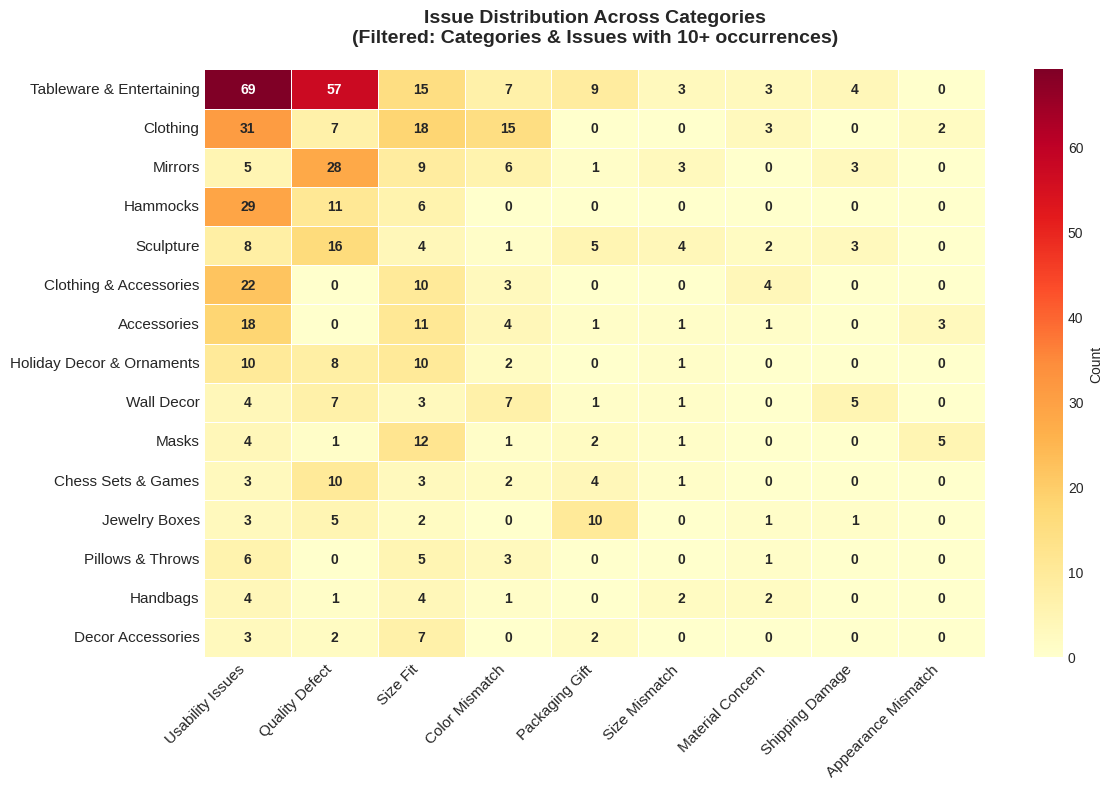


FILTERED ISSUE DATA:
issue                      Usability Issues  Quality Defect  Size Fit  \
category                                                                
Tableware & Entertaining                 69              57        15   
Clothing                                 31               7        18   
Mirrors                                   5              28         9   
Hammocks                                 29              11         6   
Sculpture                                 8              16         4   
Clothing & Accessories                   22               0        10   
Accessories                              18               0        11   
Holiday Decor & Ornaments                10               8        10   
Wall Decor                                4               7         3   
Masks                                     4               1        12   
Chess Sets & Games                        3              10         3   
Jewelry Boxes                

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_filtered_issue_heatmap(root_causes_df,
                                 min_category_total=10,
                                 min_issue_total=10,
                                 figsize=(14, 8),
                                 save_path=None):
    """
    Create a filtered heatmap showing only categories and issues with meaningful data.
    """

    # Create pivot table
    pivot_data = root_causes_df.pivot_table(
        index='category',
        columns='issue',
        values='occurrence',
        aggfunc='sum',
        fill_value=0
    )

    # Remove Jewelry category
    if 'Jewelry' in pivot_data.index:
        pivot_data = pivot_data.drop('Jewelry')

    # Filter 1: Keep only categories with total issues >= min_category_total
    category_totals = pivot_data.sum(axis=1)
    categories_to_keep = category_totals[category_totals >= min_category_total].index
    pivot_filtered = pivot_data.loc[categories_to_keep]

    # Filter 2: Keep only issues with total occurrences >= min_issue_total
    issue_totals = pivot_filtered.sum(axis=0)
    issues_to_keep = issue_totals[issue_totals >= min_issue_total].index
    pivot_filtered = pivot_filtered[issues_to_keep]

    # Filter 3: Remove any remaining rows/columns that are all zeros
    pivot_filtered = pivot_filtered.loc[(pivot_filtered.sum(axis=1) > 0)]
    pivot_filtered = pivot_filtered.loc[:, (pivot_filtered.sum(axis=0) > 0)]

    # Sort by total issues (descending)
    pivot_filtered = pivot_filtered.loc[pivot_filtered.sum(axis=1).sort_values(ascending=False).index]

    # Sort columns by total (descending)
    pivot_filtered = pivot_filtered[pivot_filtered.sum(axis=0).sort_values(ascending=False).index]

    print(f"Filtered to {len(pivot_filtered)} categories and {len(pivot_filtered.columns)} issue types")
    print(f"Original: {len(pivot_data)} categories and {len(pivot_data.columns)} issue types")

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Create heatmap
    sns.heatmap(
        pivot_filtered,
        annot=True,
        fmt='.0f',
        cmap='YlOrRd',
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Count'},
        ax=ax
    )

    # Styling
    ax.set_title('Issue Distribution Across Categories', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")

    plt.show()

    return fig, pivot_filtered


def plot_filtered_issue_heatmap_from_reviews(reviews_df,
                                              min_category_total=10,
                                              min_issue_total=10,
                                              figsize=(14, 8),
                                              save_path=None):
    """
    Create filtered heatmap directly from reviews dataframe.
    Detects issues first, then creates the filtered heatmap.
    """

    # Issue detection patterns
    ISSUE_PATTERNS = {
        'Quality Defect': [r'(broke|broken|crack|chip|defect)', r'(cheap|poor|bad) quality', r'(poorly|badly) made'],
        'Size Fit': [r'(too|very) (small|large|big|tight|loose)', r'(doesn\'t|does not) fit', r'wrong size', r'size (issue|problem)'],
        'Appearance Mismatch': [r'(looks?|looked?) (different|nothing like)', r'not (as|like) (pictured|shown|described)'],
        'Material Concern': [r'(cheap|thin|flimsy) (material|fabric)', r'(not real|fake|plated)', r'material (issue|problem|quality)'],
        'Usability Issues': [r'(uncomfortable|scratchy|itchy|heavy|stiff)', r'(hurt|irritat)', r'(not|isn\'t) comfortable', r'(hard|difficult) to (use|open|close)', r'(awkward|clunky)'],
        'Color Mismatch': [r'(color|colour).*(different|off|wrong)', r'not the (same|right) (color|colour)'],
        'Size Mismatch': [r'(smaller|larger|bigger) than (expected|pictured|thought)', r'dimensions.*(wrong|off|different)'],
        'Packaging Gift': [r'(gift|present).*(box|packaging|wrapping)', r'(no|poor|bad) (packaging|box)', r'packaging.*(damaged|poor)'],
        'Shipping Damage': [r'(arrived|came) (damaged|broken|cracked)', r'(damaged|broken) (in|during) (shipping|transit)']
    }

    import re

    # Detect issues for each review
    def detect_issues(text):
        if not isinstance(text, str):
            return []
        text_lower = text.lower()
        detected = []
        for issue_name, patterns in ISSUE_PATTERNS.items():
            for pattern in patterns:
                if re.search(pattern, text_lower):
                    detected.append(issue_name)
                    break
        return detected

    # Apply detection
    reviews_df = reviews_df.copy()
    reviews_df['detected_issues'] = reviews_df['review_text'].apply(detect_issues)

    # Build issue counts by category
    issue_data = []
    for _, row in reviews_df.iterrows():
        category = row.get('classification', 'Unknown')
        for issue in row['detected_issues']:
            issue_data.append({
                'category': category,
                'issue': issue,
                'occurrence': 1
            })

    if not issue_data:
        print("No issues detected in reviews")
        return None, None

    issue_df = pd.DataFrame(issue_data)

    # Aggregate
    issue_agg = issue_df.groupby(['category', 'issue']).agg({'occurrence': 'sum'}).reset_index()

    # Create pivot table
    pivot_data = issue_agg.pivot_table(
        index='category',
        columns='issue',
        values='occurrence',
        aggfunc='sum',
        fill_value=0
    )

    # Remove Jewelry category
    if 'Jewelry' in pivot_data.index:
        pivot_data = pivot_data.drop('Jewelry')

    # Filter categories with enough data
    category_totals = pivot_data.sum(axis=1)
    categories_to_keep = category_totals[category_totals >= min_category_total].index
    pivot_filtered = pivot_data.loc[pivot_data.index.isin(categories_to_keep)]

    # Filter issues with enough data
    issue_totals = pivot_filtered.sum(axis=0)
    issues_to_keep = issue_totals[issue_totals >= min_issue_total].index
    pivot_filtered = pivot_filtered[issues_to_keep]

    # Remove remaining empty rows/columns
    pivot_filtered = pivot_filtered.loc[(pivot_filtered.sum(axis=1) > 0)]
    pivot_filtered = pivot_filtered.loc[:, (pivot_filtered.sum(axis=0) > 0)]

    # Sort by total issues
    pivot_filtered = pivot_filtered.loc[pivot_filtered.sum(axis=1).sort_values(ascending=False).index]
    pivot_filtered = pivot_filtered[pivot_filtered.sum(axis=0).sort_values(ascending=False).index]

    print(f"\n✓ Filtered Results:")
    print(f"  Categories shown: {len(pivot_filtered)}")
    print(f"  Issue types shown: {len(pivot_filtered.columns)}")
    print(f"  Total issues displayed: {int(pivot_filtered.sum().sum())}")

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Create heatmap
    sns.heatmap(
        pivot_filtered,
        annot=True,
        fmt='.0f',
        cmap='YlOrRd',
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Count'},
        ax=ax,
        annot_kws={'size': 10, 'weight': 'bold'}
    )

    # Styling
    ax.set_title('Issue Distribution Across Categories\n(Filtered: Categories & Issues with 10+ occurrences)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\n✓ Saved: {save_path}")

    plt.show()

    return fig, pivot_filtered


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":

    reviews_df = pd.read_csv('reviews_with_bert_sentiment.csv')

    fig, filtered_data = plot_filtered_issue_heatmap_from_reviews(
        reviews_df,
        min_category_total=10,
        min_issue_total=10,
        figsize=(12, 8),
        save_path='filtered_issue_heatmap.png'
    )

    print("\n" + "="*50)
    print("FILTERED ISSUE DATA:")
    print("="*50)
    print(filtered_data)

GENERATING CATEGORY-WISE ANALYSIS REPORTS

[1/2] Analyzing categories...
   Found 22 categories with sufficient data

[2/2] Generating category dashboards...
   - Tableware & Entertaining...
Saved: ./category_reports/category_Tableware_and_Entertaining_dashboard.png


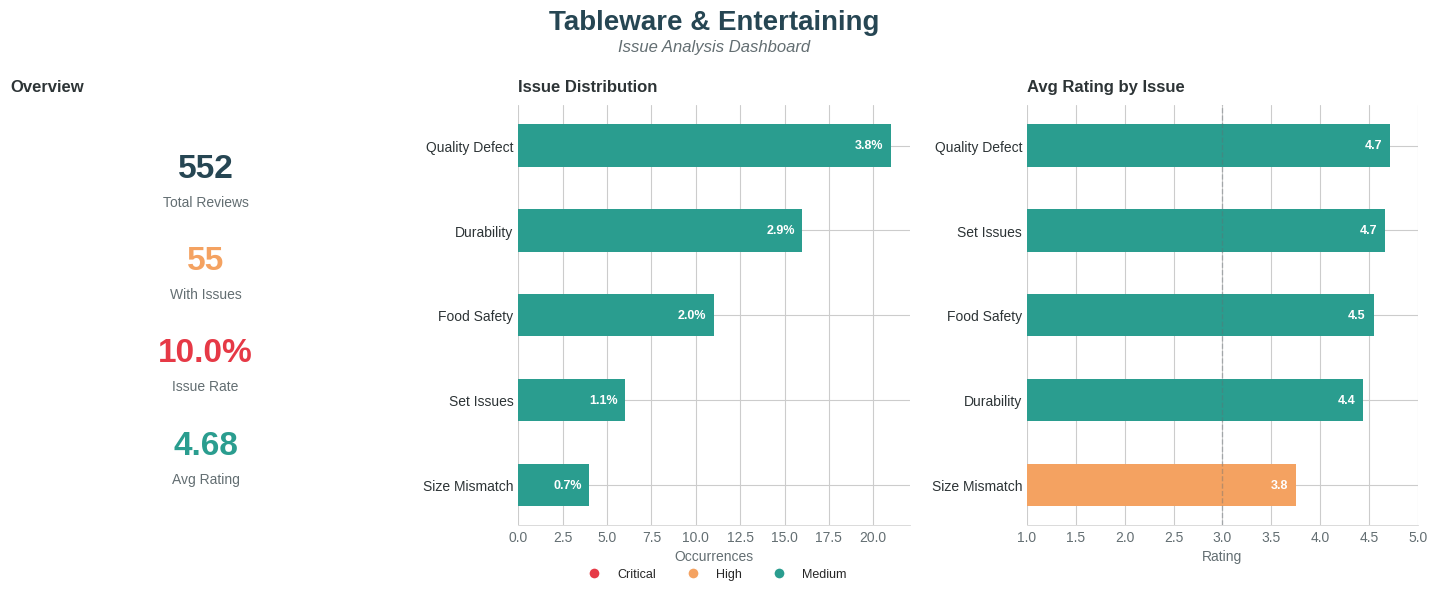

   - Outdoor Living...
Saved: ./category_reports/category_Outdoor_Living_dashboard.png


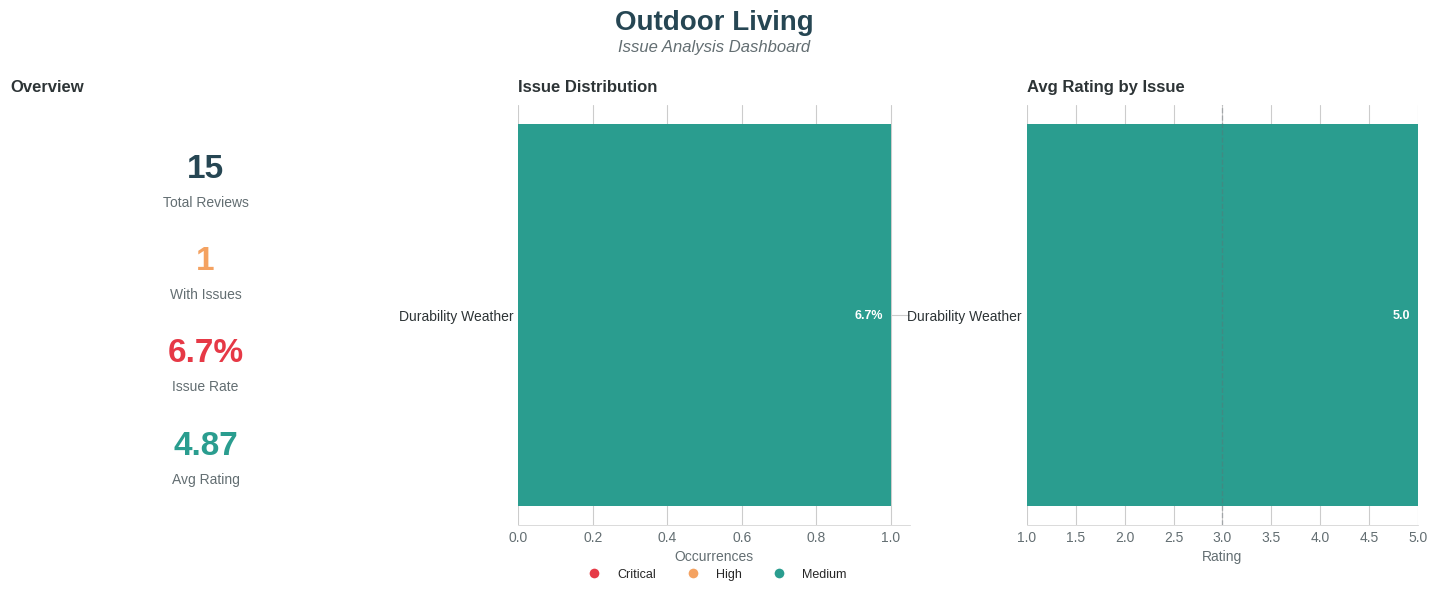

   - Sculpture...
Saved: ./category_reports/category_Sculpture_dashboard.png


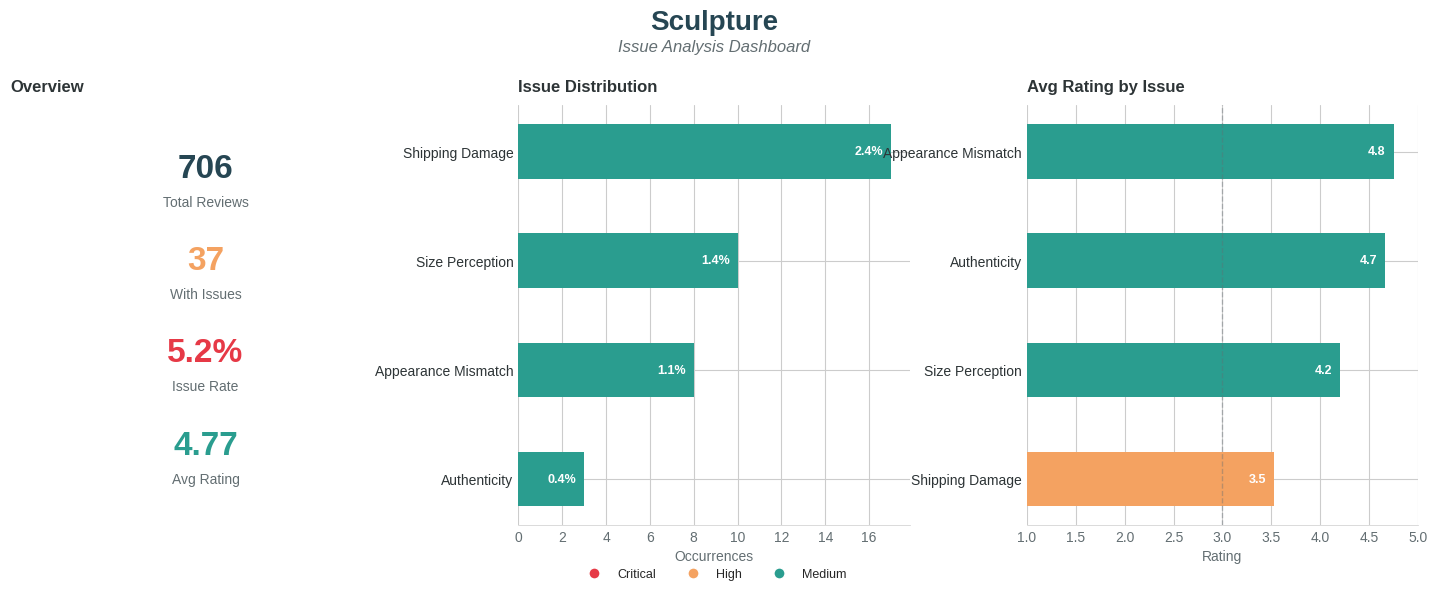

   - Mirrors...
Saved: ./category_reports/category_Mirrors_dashboard.png


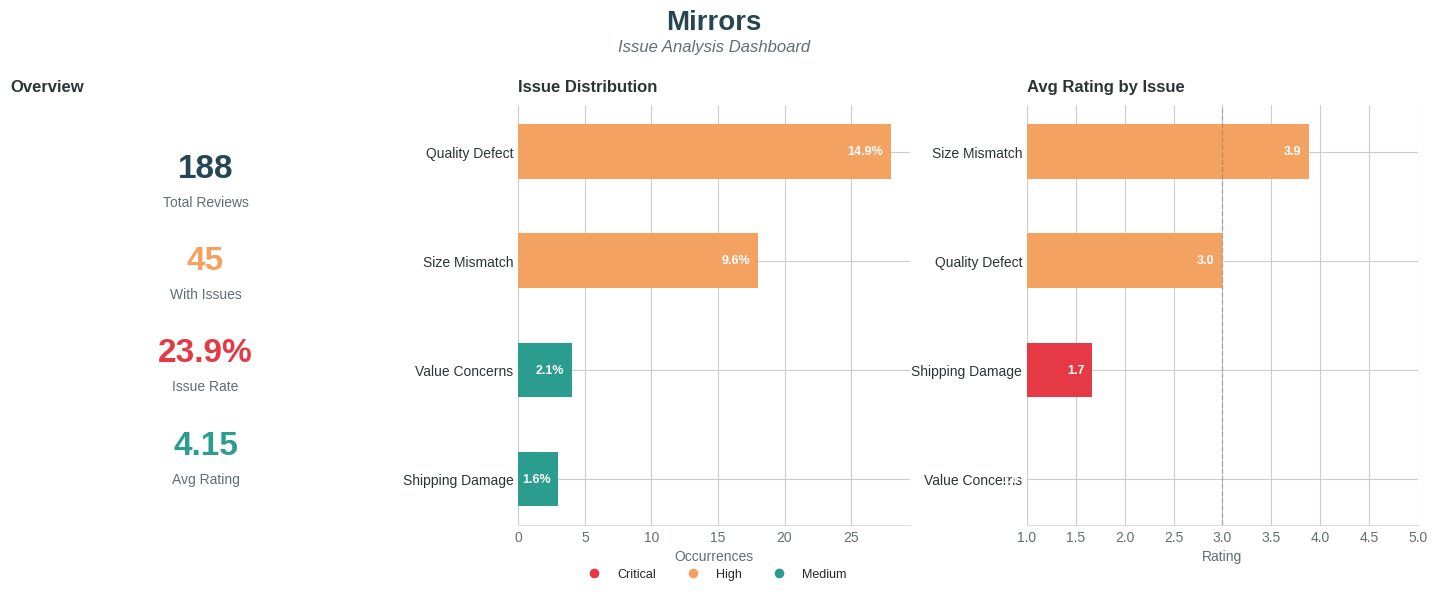

   - Jewelry...
Saved: ./category_reports/category_Jewelry_dashboard.png


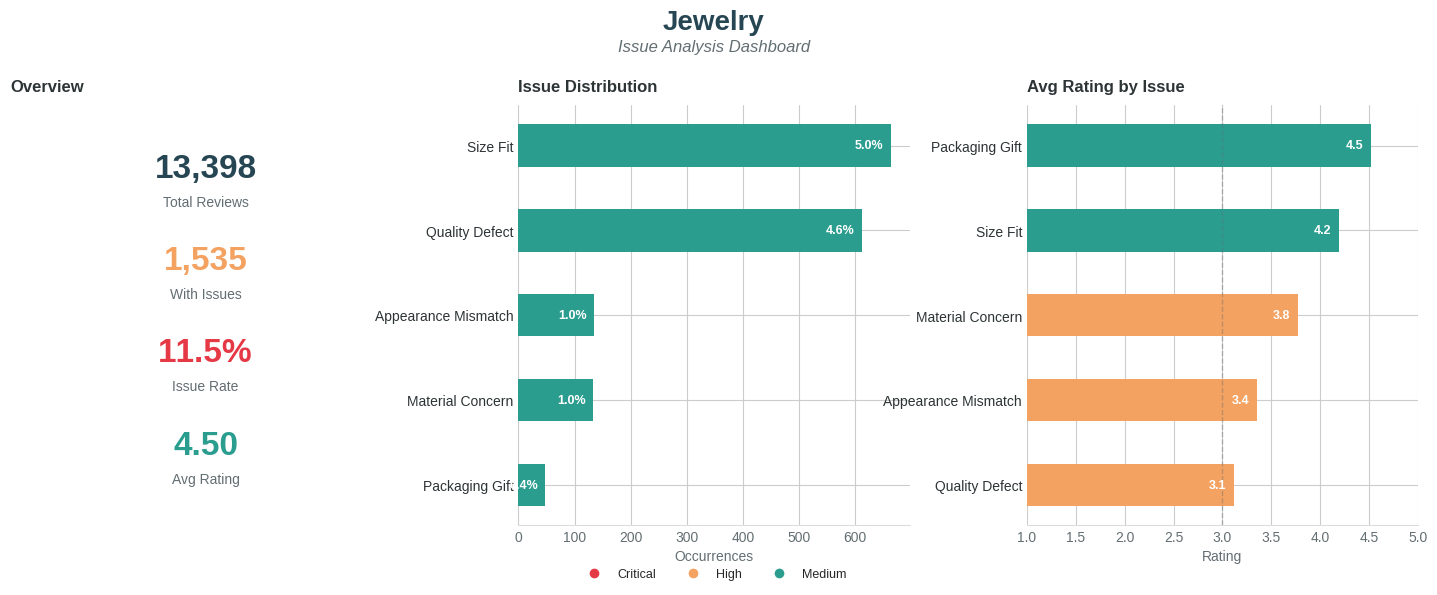

   - Chess Sets & Games...
Saved: ./category_reports/category_Chess_Sets_and_Games_dashboard.png


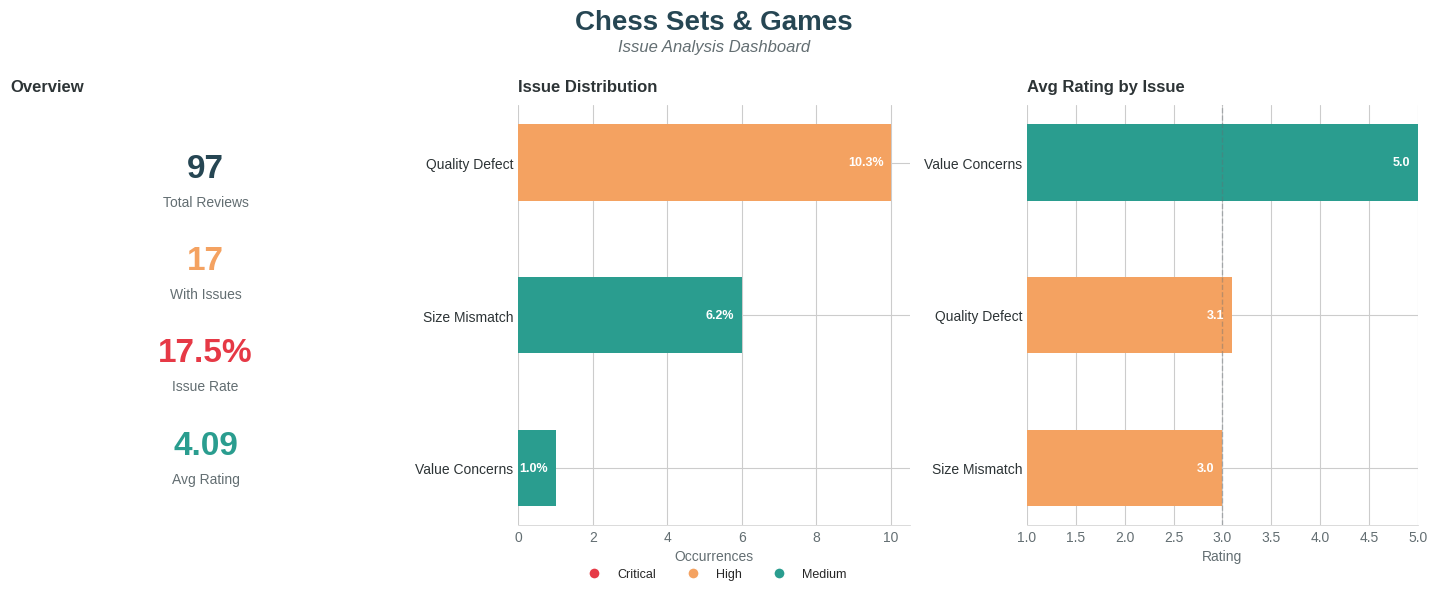

   - Decor Accessories...
Saved: ./category_reports/category_Decor_Accessories_dashboard.png


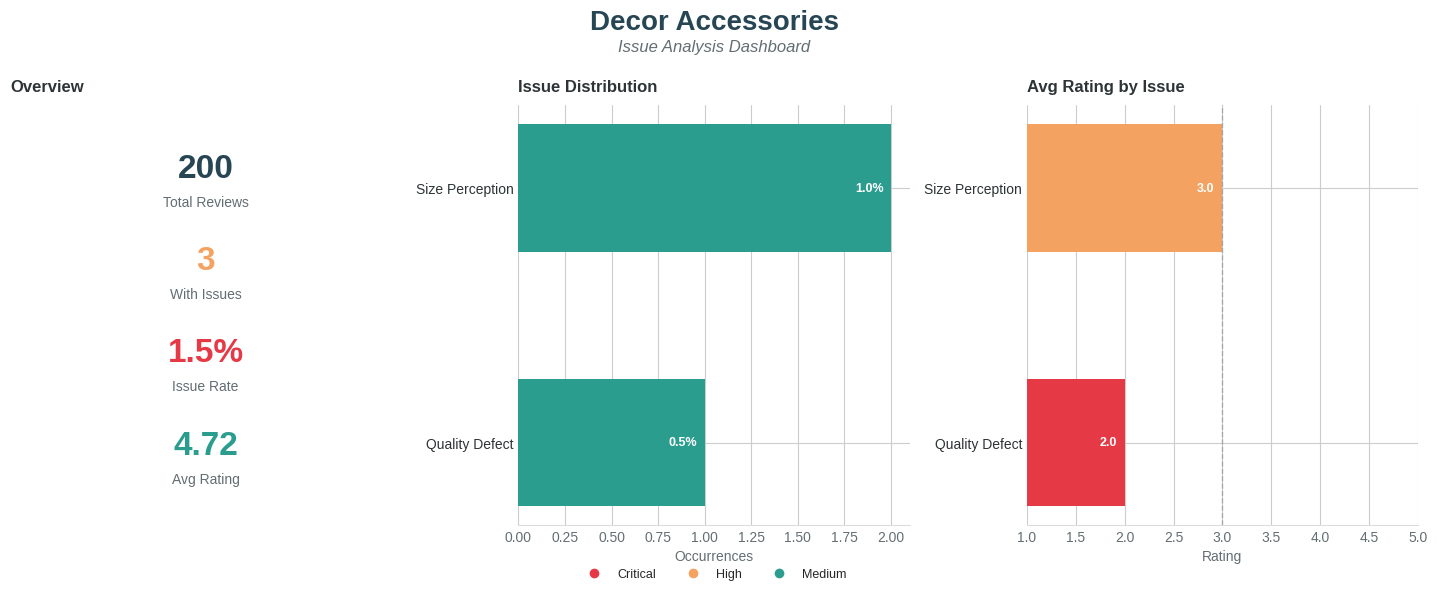

   - Masks...
Saved: ./category_reports/category_Masks_dashboard.png


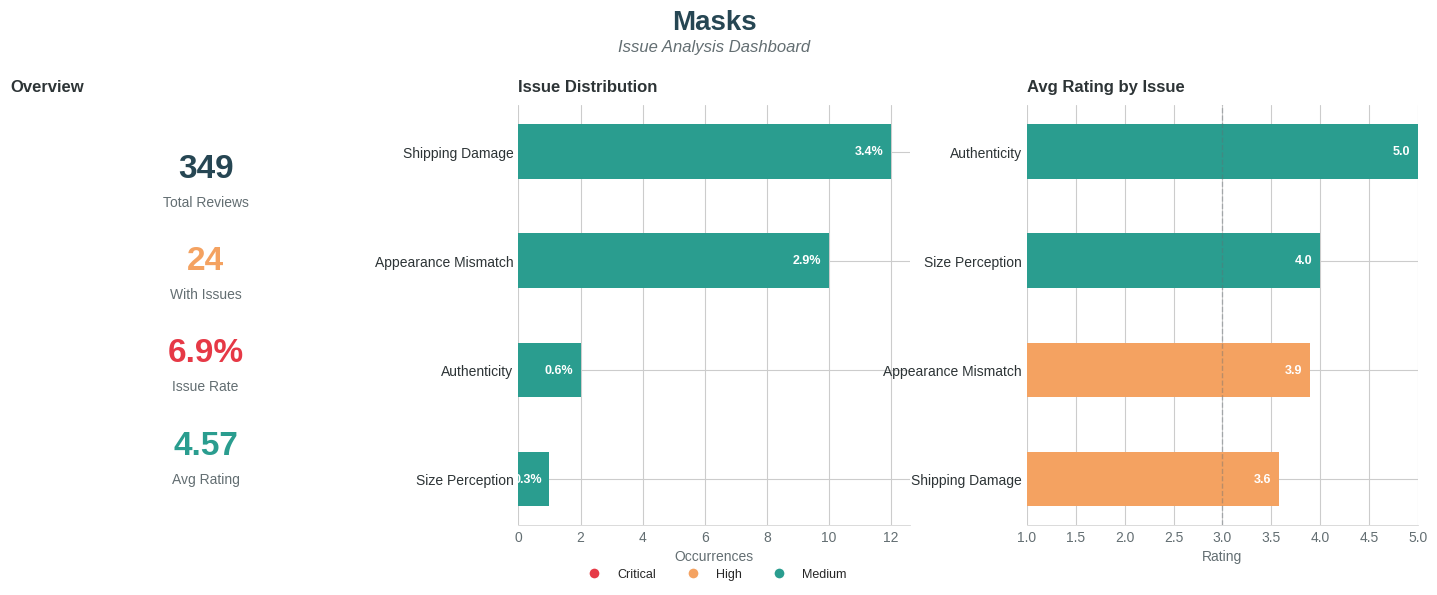

   - Hammocks...
Saved: ./category_reports/category_Hammocks_dashboard.png


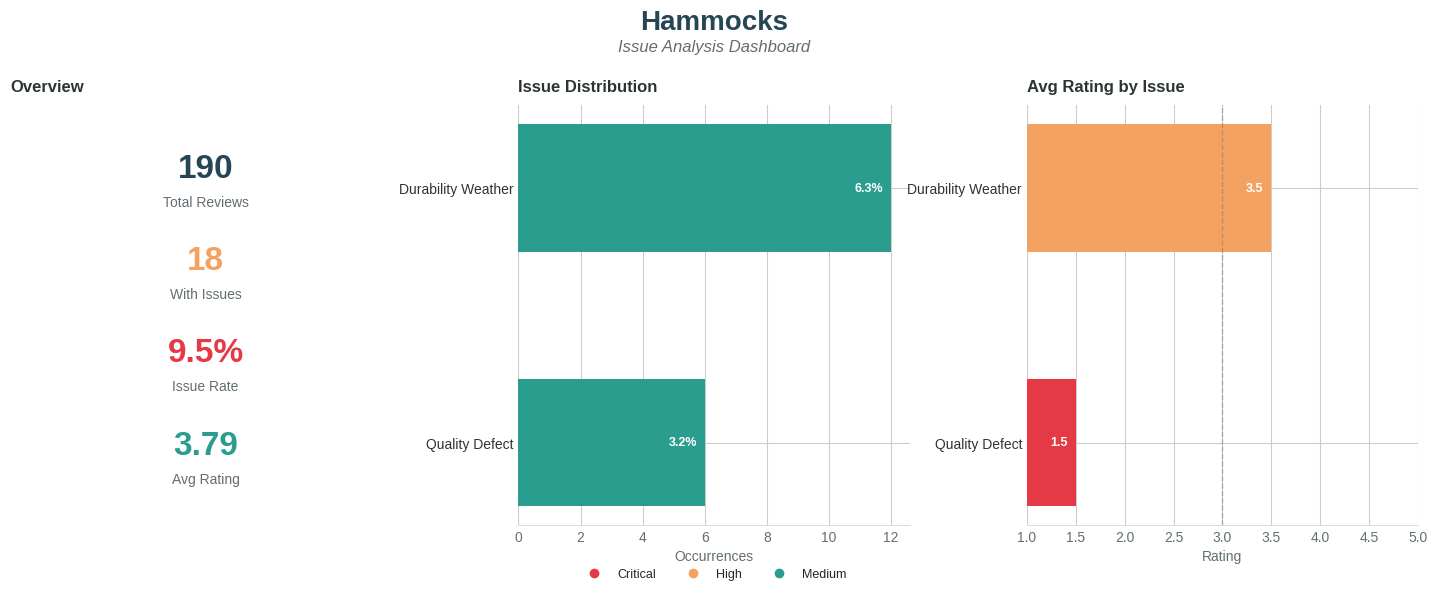

   - Vases...
Saved: ./category_reports/category_Vases_dashboard.png


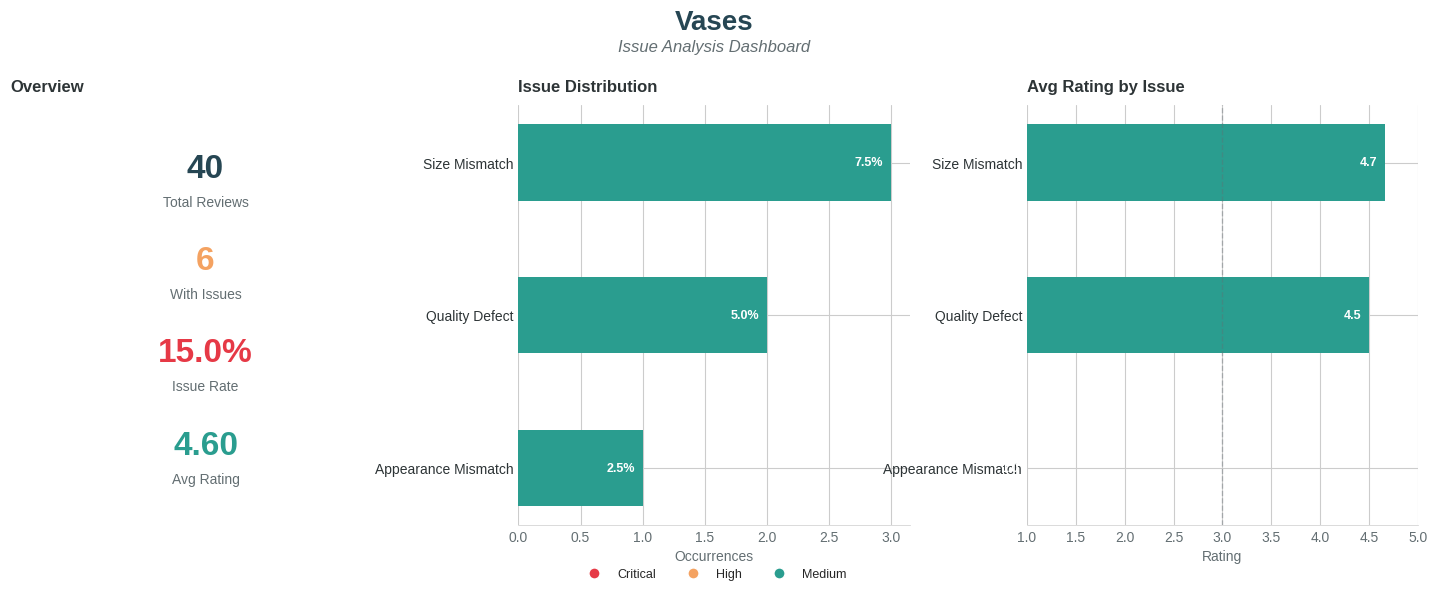

   - Clothing...
Saved: ./category_reports/category_Clothing_dashboard.png


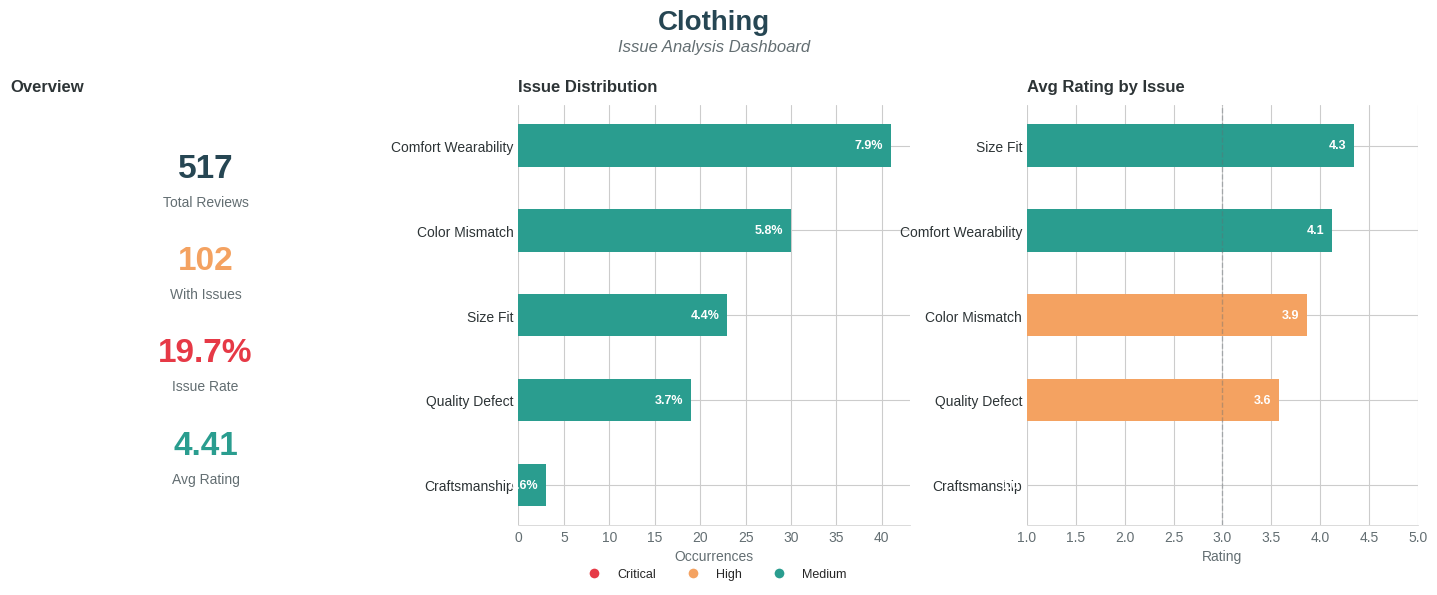

   - Clothing & Accessories...
Saved: ./category_reports/category_Clothing_and_Accessories_dashboard.png


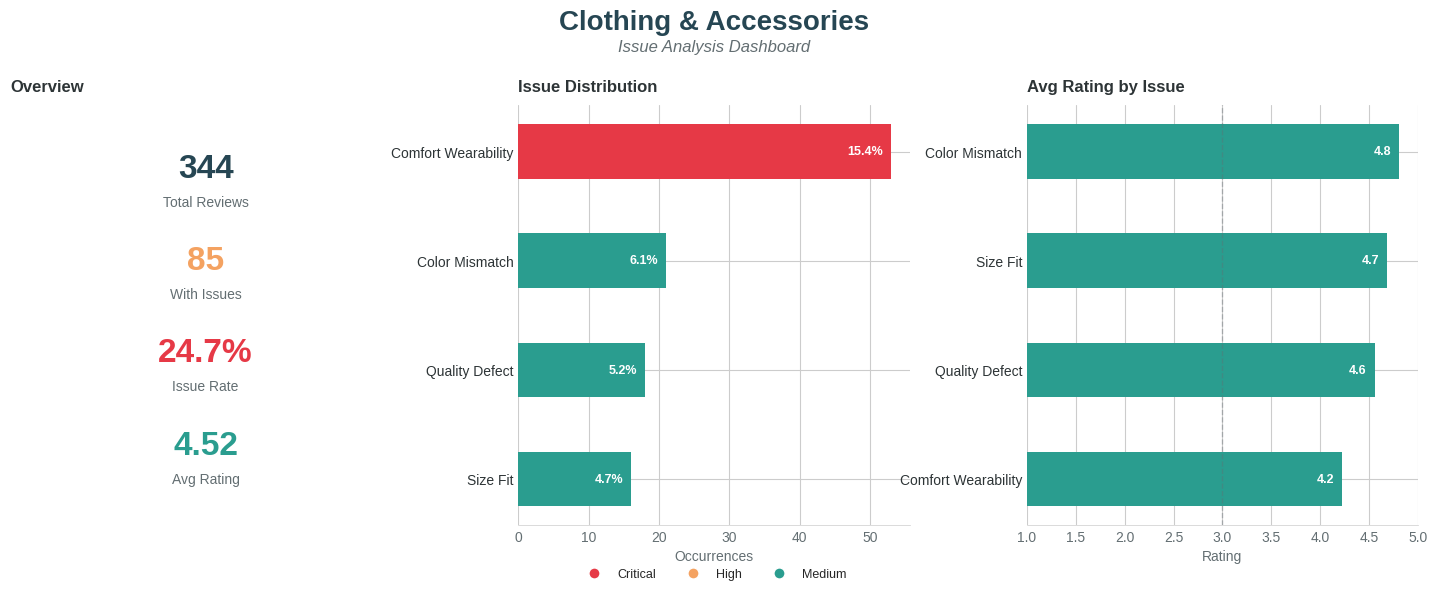

   - Accessories...
Saved: ./category_reports/category_Accessories_dashboard.png


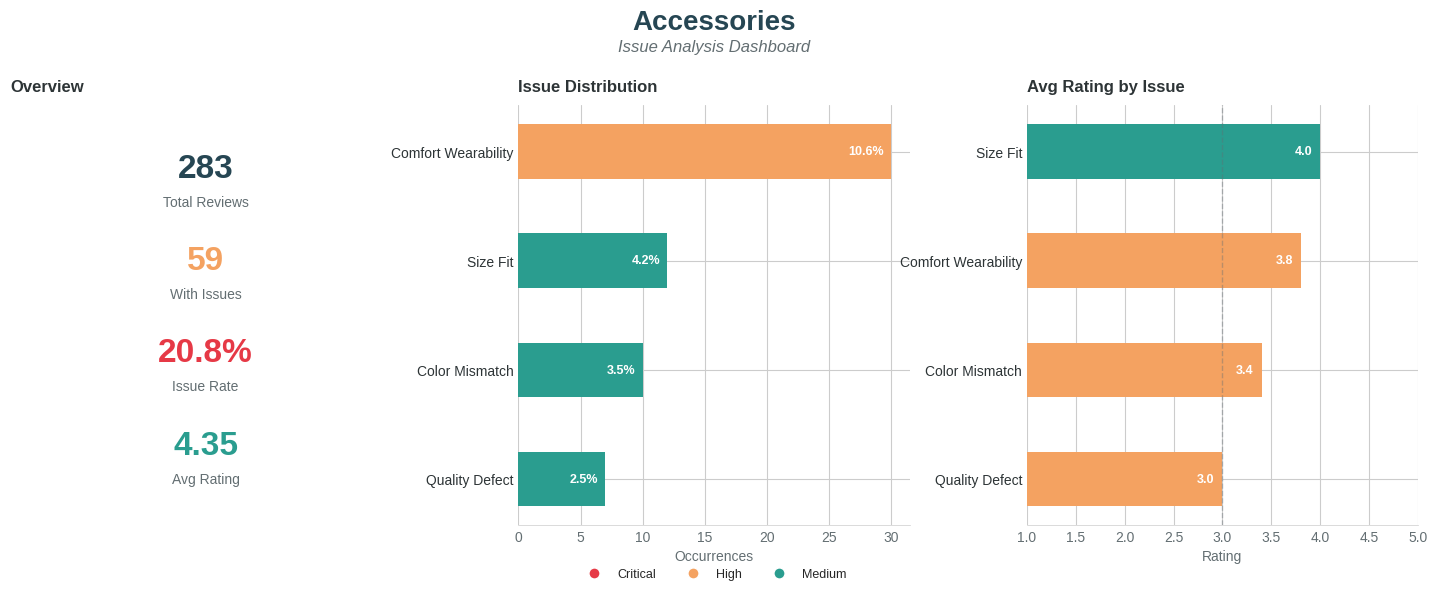

   - Furniture...
Saved: ./category_reports/category_Furniture_dashboard.png


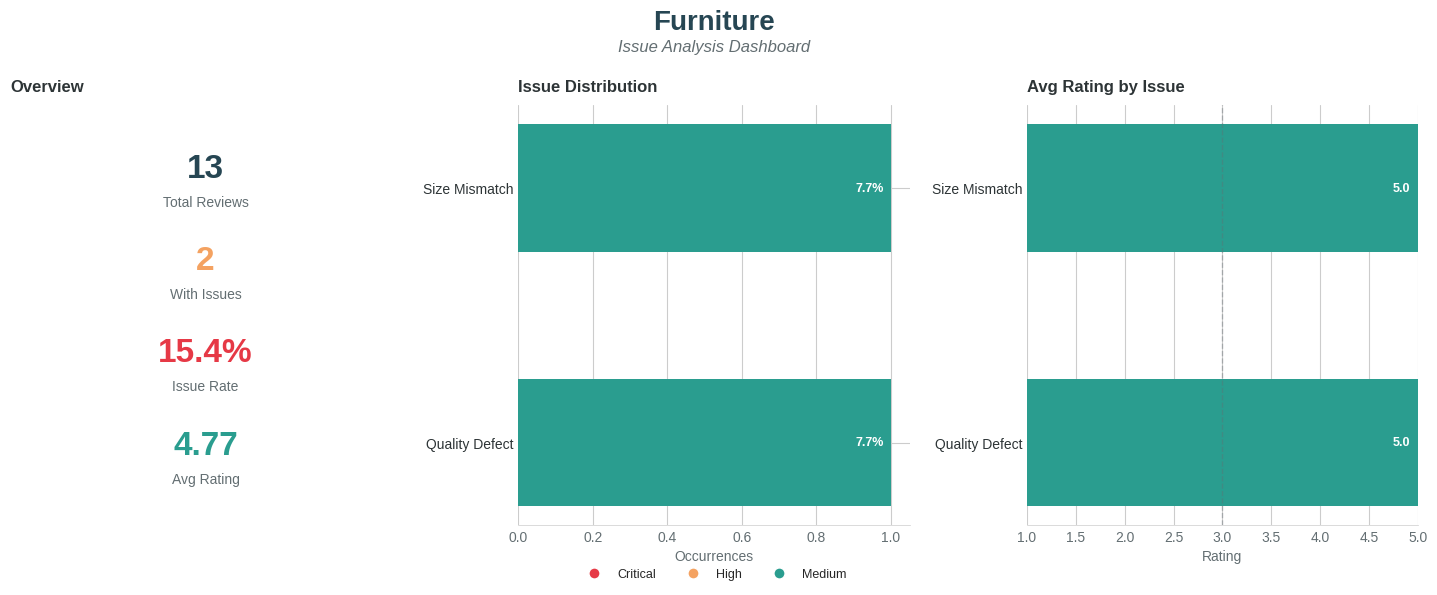

   - Jewelry Boxes...
Saved: ./category_reports/category_Jewelry_Boxes_dashboard.png


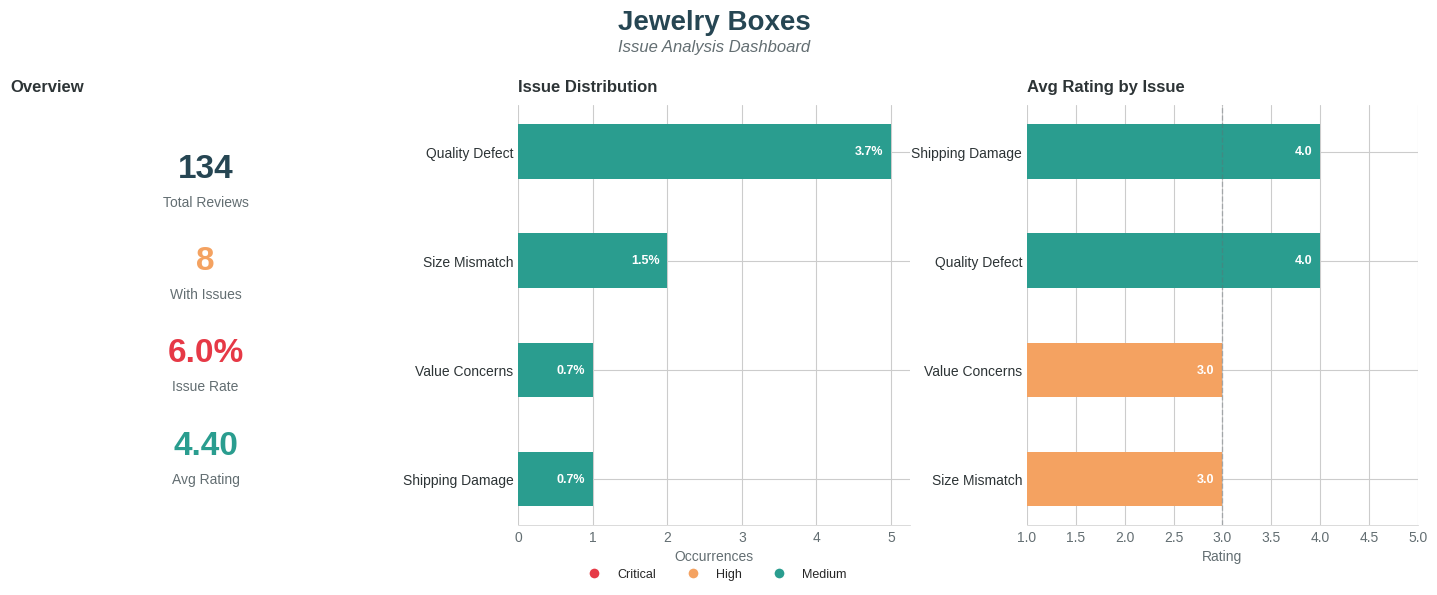

   - Lamps & Lighting...
Saved: ./category_reports/category_Lamps_and_Lighting_dashboard.png


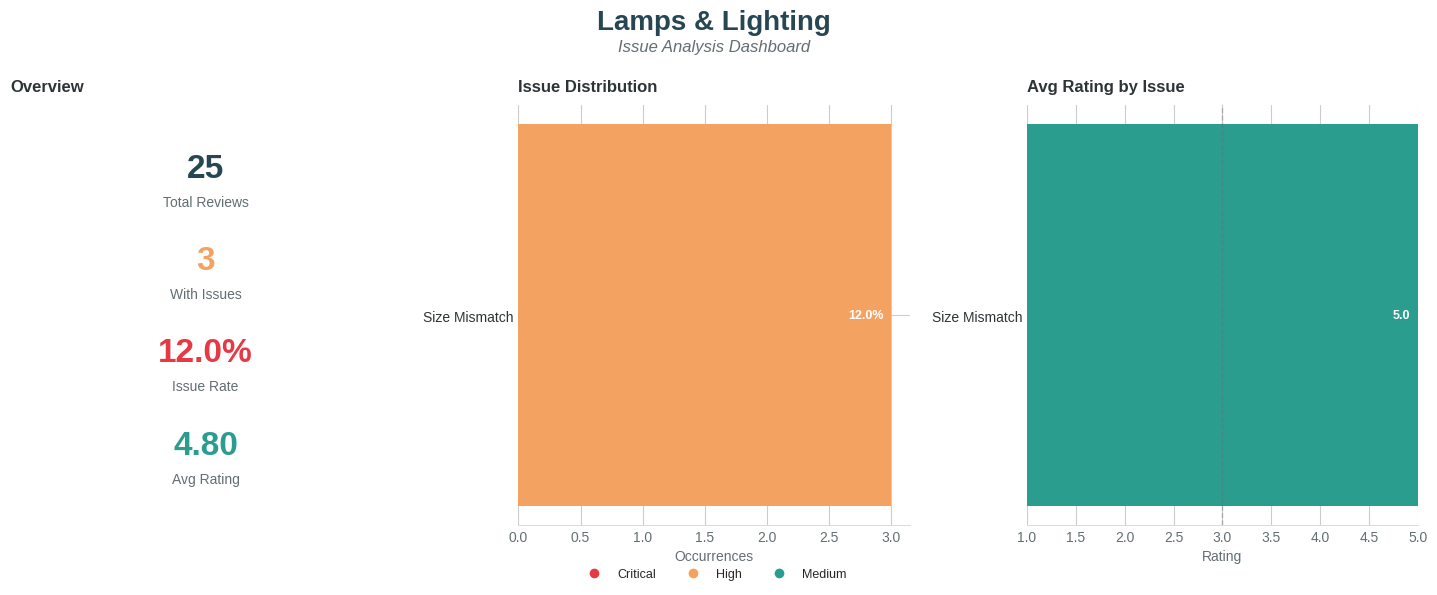

   - Musical Instruments...
Saved: ./category_reports/category_Musical_Instruments_dashboard.png


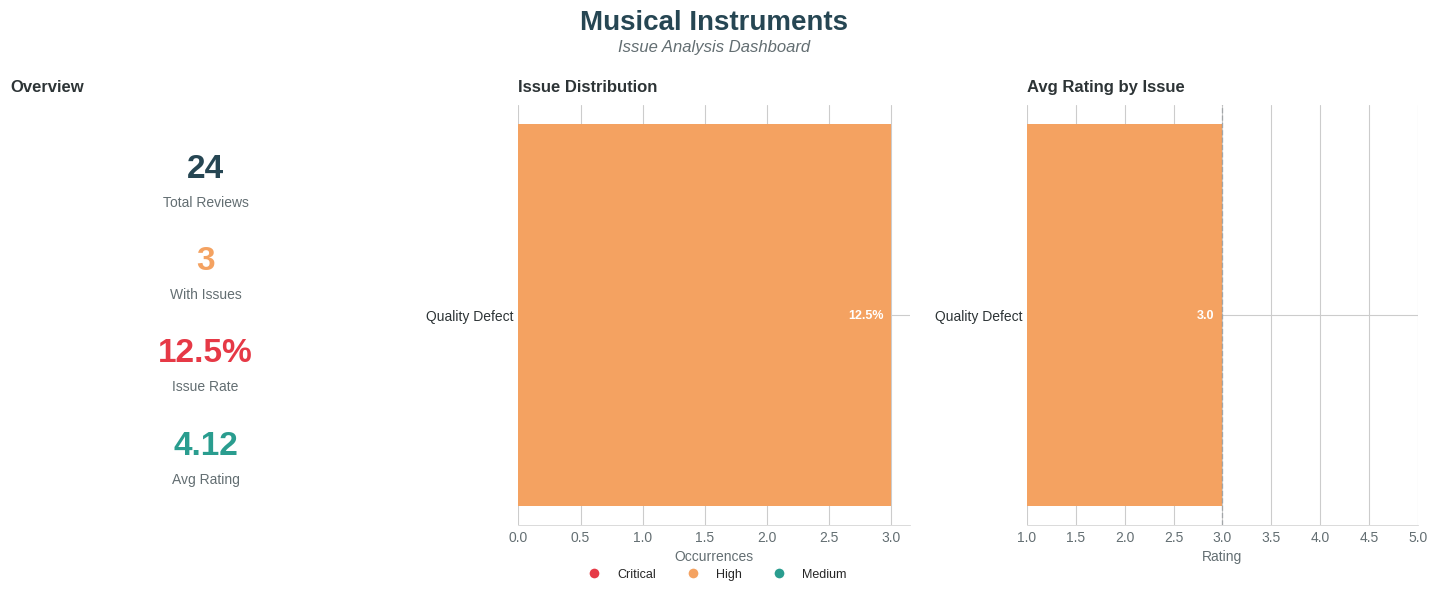

   - Home Decor...
No issues found for Home Decor
   - Wall Decor...
Saved: ./category_reports/category_Wall_Decor_dashboard.png


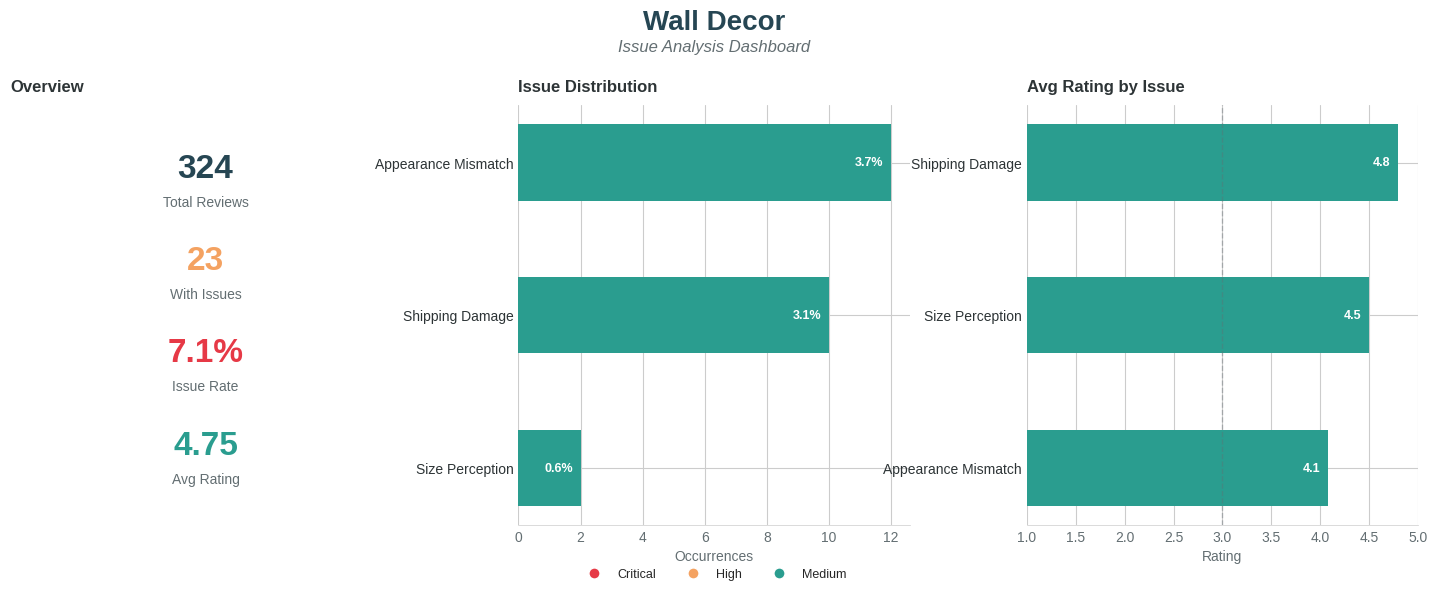

   - Holiday Decor & Ornaments...
Saved: ./category_reports/category_Holiday_Decor_and_Ornaments_dashboard.png


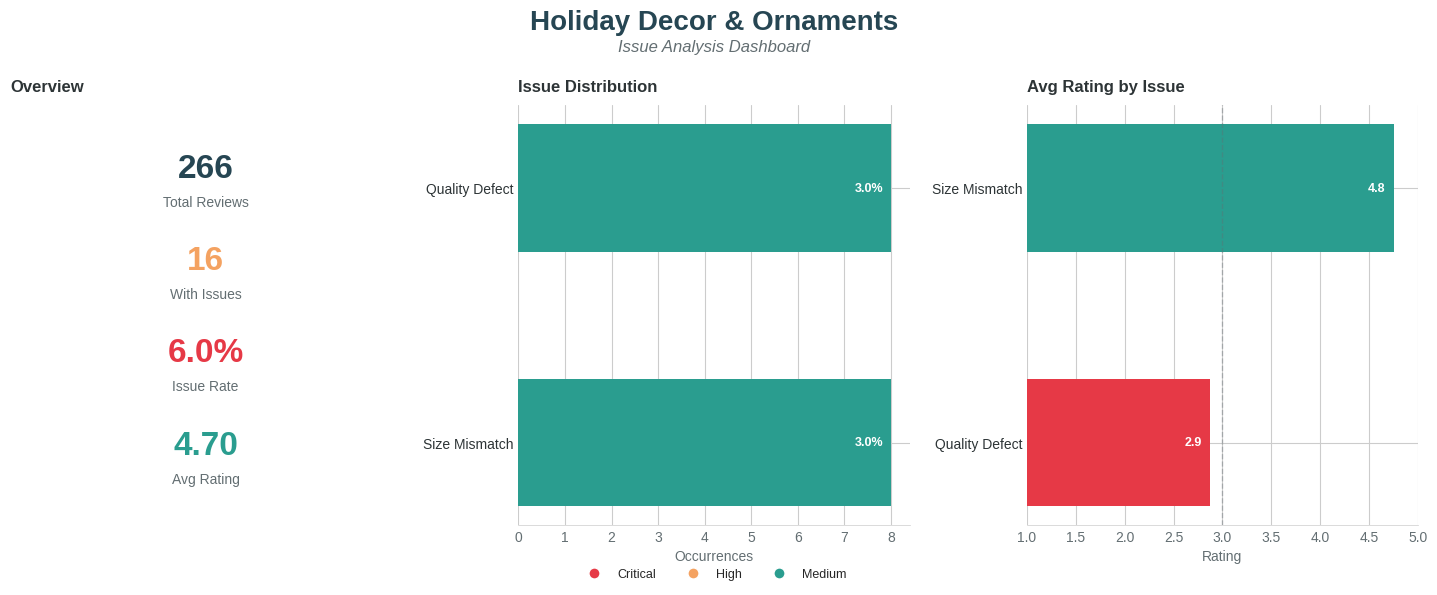

   - Pillows & Throws...
Saved: ./category_reports/category_Pillows_and_Throws_dashboard.png


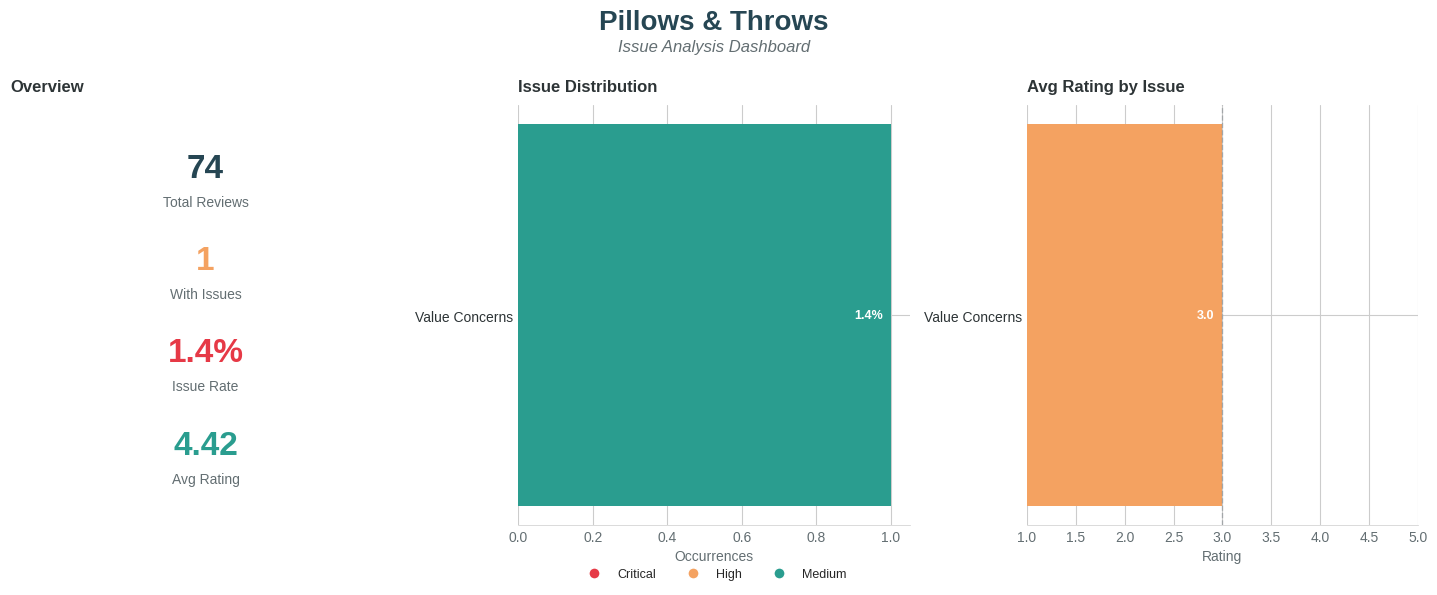

   - Handbags...
Saved: ./category_reports/category_Handbags_dashboard.png


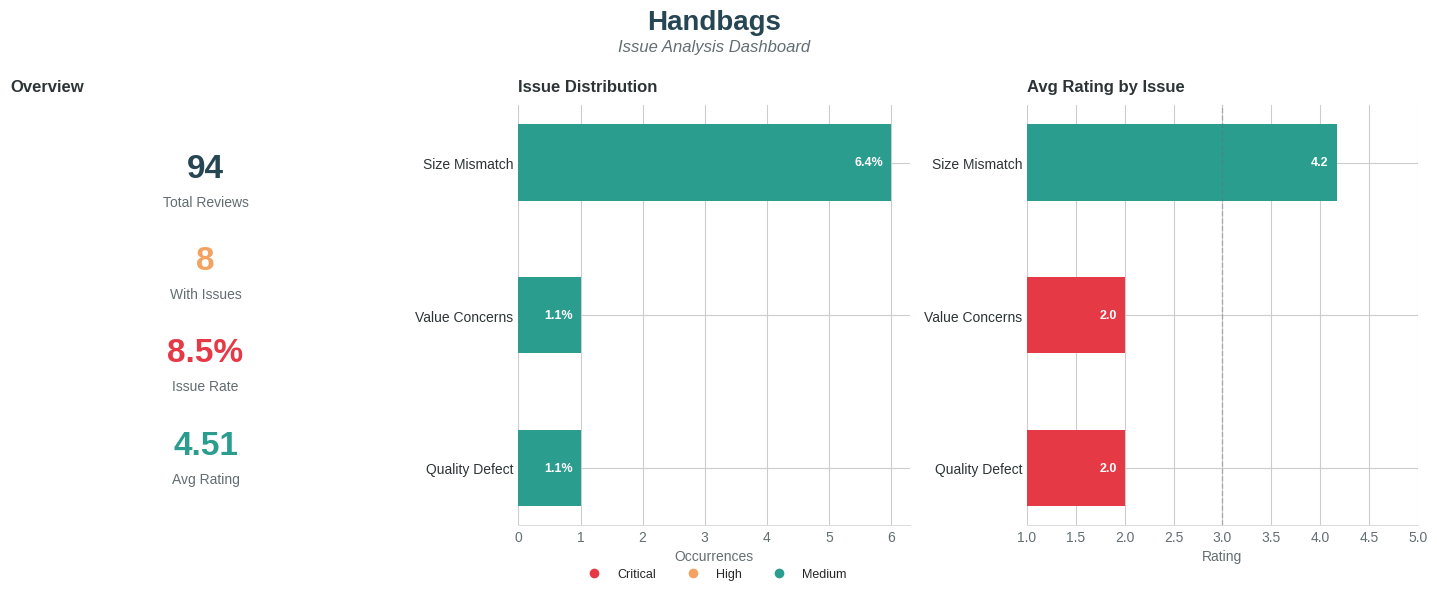


REPORTS SAVED TO: ./category_reports/

CATEGORY SUMMARY

Clothing & Accessories:
  Reviews: 344, Issue Rate: 24.7%
  Top Issues: Comfort Wearability, Color Mismatch, Quality Defect

Mirrors:
  Reviews: 188, Issue Rate: 23.9%
  Top Issues: Quality Defect, Size Mismatch, Value Concerns

Accessories:
  Reviews: 283, Issue Rate: 20.8%
  Top Issues: Comfort Wearability, Size Fit, Color Mismatch

Clothing:
  Reviews: 517, Issue Rate: 19.7%
  Top Issues: Comfort Wearability, Color Mismatch, Size Fit

Chess Sets & Games:
  Reviews: 97, Issue Rate: 17.5%
  Top Issues: Quality Defect, Size Mismatch, Value Concerns

Furniture:
  Reviews: 13, Issue Rate: 15.4%
  Top Issues: Quality Defect, Size Mismatch

Vases:
  Reviews: 40, Issue Rate: 15.0%
  Top Issues: Size Mismatch, Quality Defect, Appearance Mismatch

Musical Instruments:
  Reviews: 24, Issue Rate: 12.5%
  Top Issues: Quality Defect

Lamps & Lighting:
  Reviews: 25, Issue Rate: 12.0%
  Top Issues: Size Mismatch

Jewelry:
  Reviews: 13398, 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Clean aesthetic style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.edgecolor'] = '#CCCCCC'

# Color palette - modern and clean
COLORS = {
    'critical': '#E63946',
    'high': '#F4A261',
    'medium': '#2A9D8F',
    'accent': '#264653',
    'light_bg': '#F8F9FA',
    'text': '#2D3436',
    'muted': '#636E72'
}


class CategoryIssueAnalyzer:
    """Analyzes issues specific to each product category."""

    CATEGORY_SPECIFIC_ISSUES = {
        'Jewelry': {
            'issues': {
                'size_fit': [r'(too|very) (small|large|big|tight|loose)', r'(doesn\'t|does not) fit', r'ring size', r'bracelet.*(tight|loose)'],
                'quality_defect': [r'(broke|broken|tarnish|fade|discolor)', r'(clasp|chain|stone).*(broke|fell|missing)', r'cheap (looking|quality)'],
                'appearance_mismatch': [r'(color|stone|gem).*(different|wrong)', r'not (as|like) (pictured|shown)', r'looks (cheap|fake|different)'],
                'material_concern': [r'(not real|fake|plated|thin) (silver|gold|metal)', r'(allergic|reaction|irritat)', r'(green|discolor).*(skin|finger)'],
                'packaging_gift': [r'(gift|present).*(box|packaging)', r'no (box|pouch|bag)', r'packaging.*(poor|damaged)']
            }
        },
        'Furniture': {
            'issues': {
                'size_mismatch': [r'(smaller|larger|bigger) than (expected|thought|pictured)', r'dimensions.*(wrong|off|different)', r'(doesn\'t|does not) fit'],
                'quality_defect': [r'(wobbly|unstable|crooked|uneven)', r'(crack|split|chip|scratch)', r'(poorly|badly) (made|constructed|assembled)'],
                'assembly_issues': [r'(difficult|hard|impossible) (to assemble|assembly)', r'(missing|wrong) (parts|pieces|hardware|screws)', r'instructions.*(poor|unclear|missing)'],
                'shipping_damage': [r'(arrived|came) (damaged|broken|cracked|scratched)', r'(poor|bad|no) (packaging|protection)', r'(dent|ding|mark)'],
                'material_quality': [r'(cheap|thin|flimsy) (wood|material)', r'(veneer|particleboard|mdf)', r'not (solid|real) wood']
            }
        },
        'Home Décor': {
            'issues': {
                'size_perception': [r'(smaller|larger|bigger) than (expected|pictured)', r'(tiny|huge|massive)', r'scale.*(wrong|off)'],
                'appearance_mismatch': [r'(color|colours?).*(different|off|wrong)', r'not (as|like) (pictured|shown|described)', r'looks (different|cheap|nothing like)'],
                'quality_defect': [r'(cheap|flimsy|poorly) (made|quality)', r'(broken|cracked|chipped)', r'(paint|finish).*(chip|peel|uneven)'],
                'shipping_damage': [r'(arrived|came) (broken|damaged|shattered)', r'(glass|ceramic).*(broke|cracked)', r'(no|poor) (packaging|protection)'],
                'hanging_display': [r'(no|missing) (hook|hanger|hardware)', r'(difficult|hard) to (hang|display|mount)', r'(heavy|weight).*(hang|wall)']
            }
        },
        'Tableware & Entertaining': {
            'issues': {
                'size_mismatch': [r'(smaller|larger) than (expected|standard)', r'(tiny|small) (portion|serving|glass)', r'(doesn\'t|does not) hold (much|enough)'],
                'quality_defect': [r'(chip|crack|rough) (edge|rim)', r'(uneven|wobbly|tippy)', r'(bubble|flaw|imperfection)'],
                'food_safety': [r'(dishwasher|microwave).*(safe|unsafe)', r'(lead|cadmium|toxic)', r'(not food|paint).*(safe)'],
                'durability': [r'(broke|cracked|chipped) (after|first|easy)', r'(fragile|delicate)', r'(doesn\'t|does not) (last|hold up)'],
                'set_issues': [r'(missing|broken) (piece|item)', r'(don\'t|doesn\'t) match', r'(uneven|different) (size|color)']
            }
        },
        'Apparel & Accessories': {
            'issues': {
                'size_fit': [r'(too|very) (small|large|big|tight|loose|short|long)', r'(doesn\'t|does not) fit', r'size (chart|guide).*(wrong|off|inaccurate)'],
                'quality_defect': [r'(thin|cheap|flimsy) (fabric|material)', r'(loose|missing) (thread|stitch|button)', r'(tear|rip|hole|fray)'],
                'color_mismatch': [r'(color|colour).*(different|off|wrong|faded)', r'not (as|like) (pictured|shown)', r'(dye|bleed|fade)'],
                'comfort_wearability': [r'(uncomfortable|scratchy|itchy)', r'(shrink|shrunk) (after|when) wash', r'(hot|heavy|stiff)'],
                'craftsmanship': [r'(uneven|crooked|sloppy) (stitch|seam|hem)', r'(poor|bad) (quality|workmanship)', r'(cheap|poorly) made']
            }
        },
        'Art': {
            'issues': {
                'size_perception': [r'(smaller|larger) than (expected|thought)', r'(tiny|huge)', r'scale.*(wrong|misleading)'],
                'appearance_mismatch': [r'(color|colours?).*(different|off)', r'not (as|like) (pictured|vibrant)', r'(dull|faded|dark)'],
                'quality_framing': [r'(frame|framing).*(cheap|poor|damaged)', r'(no|without) frame', r'(glass|acrylic).*(scratch|crack)'],
                'shipping_damage': [r'(arrived|came) (damaged|bent|creased)', r'(tear|rip|crease|fold)', r'(poor|no) (packaging|protection)'],
                'authenticity': [r'(print|copy|reproduction)', r'not (original|authentic|hand)', r'(fake|mass produced)']
            }
        },
        'Outdoor Living': {
            'issues': {
                'durability_weather': [r'(rust|fade|deteriorat|weather)', r'not (outdoor|weather).*(safe|proof|resistant)', r'(rain|sun|uv).*(damage|fade)'],
                'size_mismatch': [r'(smaller|larger) than (expected|pictured)', r'(doesn\'t|does not) fit', r'dimensions.*(wrong|off)'],
                'quality_defect': [r'(broke|broken|crack|chip)', r'(wobbly|unstable|flimsy)', r'(cheap|poor) (quality|construction)'],
                'assembly_issues': [r'(difficult|hard) (to assemble|assembly)', r'(missing|wrong) (parts|hardware)', r'instructions.*(poor|missing)'],
                'shipping_damage': [r'(arrived|came) (damaged|broken|dented)', r'(poor|bad) packaging']
            }
        }
    }

    DEFAULT_ISSUES = {
        'issues': {
            'quality_defect': [r'(broke|broken|crack|chip|defect)', r'(cheap|poor|bad) quality', r'(poorly|badly) made'],
            'size_mismatch': [r'(smaller|larger|bigger) than', r'(doesn\'t|does not) fit', r'wrong size'],
            'appearance_mismatch': [r'(color|looks?) (different|wrong|off)', r'not (as|like) (pictured|shown)'],
            'shipping_damage': [r'(arrived|came) (damaged|broken)', r'(poor|bad) packaging'],
            'value_concerns': [r'(not|isn\'t) worth', r'(overpriced|too expensive)', r'waste.* money']
        }
    }

    def __init__(self):
        self.results = {}

    def get_category_config(self, category):
        category_mapping = {
            'Jewelry': 'Jewelry', 'Furniture': 'Furniture',
            'Home Décor': 'Home Décor', 'Home Decor': 'Home Décor',
            'Decor Accessories': 'Home Décor',
            'Tableware & Entertaining': 'Tableware & Entertaining',
            'Apparel & Accessories': 'Apparel & Accessories',
            'Clothing': 'Apparel & Accessories',
            'Clothing & Accessories': 'Apparel & Accessories',
            'Accessories': 'Apparel & Accessories',
            'Art': 'Art', 'Masks': 'Art', 'Sculpture': 'Art', 'Wall Decor': 'Art',
            'Outdoor Living': 'Outdoor Living', 'Hammocks': 'Outdoor Living'
        }
        mapped = category_mapping.get(category, None)
        if mapped and mapped in self.CATEGORY_SPECIFIC_ISSUES:
            return self.CATEGORY_SPECIFIC_ISSUES[mapped]
        return self.DEFAULT_ISSUES

    def detect_issues_for_category(self, text, category):
        if not isinstance(text, str):
            return []
        text_lower = text.lower()
        config = self.get_category_config(category)
        detected = []
        for issue_type, patterns in config['issues'].items():
            for pattern in patterns:
                if re.search(pattern, text_lower):
                    detected.append(issue_type)
                    break
        return detected

    def analyze_category(self, reviews_df, category):
        cat_reviews = reviews_df[reviews_df['classification'] == category].copy()
        if len(cat_reviews) < 5:
            return None

        cat_reviews['detected_issues'] = cat_reviews['review_text'].apply(
            lambda x: self.detect_issues_for_category(x, category))

        issue_counts = Counter()
        issue_by_rating = defaultdict(list)

        for _, row in cat_reviews.iterrows():
            for issue in row['detected_issues']:
                issue_counts[issue] += 1
                issue_by_rating[issue].append(row.get('review_star', 3))

        total_reviews = len(cat_reviews)
        total_with_issues = len(cat_reviews[cat_reviews['detected_issues'].apply(len) > 0])

        issue_summary = []
        for issue, count in issue_counts.items():
            avg_rating = np.mean(issue_by_rating[issue]) if issue_by_rating[issue] else 0
            issue_summary.append({
                'issue': issue.replace('_', ' ').title(),
                'count': count,
                'percentage': count / total_reviews * 100,
                'avg_rating_when_mentioned': avg_rating,
                'severity': 'Critical' if count/total_reviews > 0.15 else ('High' if count/total_reviews > 0.08 else 'Medium')
            })

        return {
            'category': category,
            'total_reviews': total_reviews,
            'reviews_with_issues': total_with_issues,
            'issue_rate': total_with_issues / total_reviews * 100,
            'avg_rating': cat_reviews['review_star'].mean(),
            'avg_sentiment': cat_reviews['vader_compound'].mean() if 'vader_compound' in cat_reviews.columns else None,
            'issues': sorted(issue_summary, key=lambda x: x['count'], reverse=True)
        }

    def analyze_all_categories(self, reviews_df):
        categories = reviews_df['classification'].dropna().unique()
        results = {}
        for category in categories:
            analysis = self.analyze_category(reviews_df, category)
            if analysis:
                results[category] = analysis
        self.results = results
        return results


def plot_category_issue_dashboard(category_analysis, figsize=(16, 6), save_path=None):
    """Create a clean 3-panel dashboard: Overview, Issues, Avg Rating."""

    category = category_analysis['category']
    issues = category_analysis['issues']

    if not issues:
        print(f"No issues found for {category}")
        return None

    # Create figure with custom background
    fig = plt.figure(figsize=figsize, facecolor='white')

    # Main title with elegant styling
    fig.suptitle(category, fontsize=20, fontweight='bold', color=COLORS['accent'], y=0.98)
    fig.text(0.5, 0.91, 'Issue Analysis Dashboard', fontsize=12, color=COLORS['muted'],
             ha='center', style='italic')

    # Create 3-panel layout
    gs = fig.add_gridspec(1, 3, wspace=0.3, left=0.06, right=0.94, top=0.82, bottom=0.12)

    # ─────────────────────────────────────────────────────────────
    # Panel 1: Category Overview (Clean Card Style)
    # ─────────────────────────────────────────────────────────────
    ax_metrics = fig.add_subplot(gs[0, 0])
    ax_metrics.axis('off')

    # Create metric cards
    metrics = [
        ('Total Reviews', f"{category_analysis['total_reviews']:,}", COLORS['accent']),
        ('With Issues', f"{category_analysis['reviews_with_issues']:,}", COLORS['high']),
        ('Issue Rate', f"{category_analysis['issue_rate']:.1f}%", COLORS['critical']),
        ('Avg Rating', f"{category_analysis['avg_rating']:.2f}", COLORS['medium'])
    ]

    for i, (label, value, color) in enumerate(metrics):
        y_pos = 0.85 - (i * 0.22)

        # Value (large)
        ax_metrics.text(0.5, y_pos, value, transform=ax_metrics.transAxes,
                       fontsize=24, fontweight='bold', color=color,
                       ha='center', va='center')
        # Label (small, muted)
        ax_metrics.text(0.5, y_pos - 0.08, label, transform=ax_metrics.transAxes,
                       fontsize=10, color=COLORS['muted'],
                       ha='center', va='center')

    ax_metrics.set_title('Overview', fontsize=12, fontweight='bold',
                         color=COLORS['text'], pad=10, loc='left')

    # ─────────────────────────────────────────────────────────────
    # Panel 2: Issues Bar Chart (Clean Horizontal Bars)
    # ─────────────────────────────────────────────────────────────
    ax_issues = fig.add_subplot(gs[0, 1])
    issue_df = pd.DataFrame(issues)

    if len(issue_df) > 0:
        issue_df_sorted = issue_df.sort_values('count', ascending=True)

        # Gradient colors based on severity
        colors = [COLORS['critical'] if s == 'Critical' else (COLORS['high'] if s == 'High' else COLORS['medium'])
                  for s in issue_df_sorted['severity']]

        y_pos = range(len(issue_df_sorted))
        bars = ax_issues.barh(y_pos, issue_df_sorted['count'], color=colors,
                              height=0.5, edgecolor='none')

        ax_issues.set_yticks(y_pos)
        ax_issues.set_yticklabels(issue_df_sorted['issue'], fontsize=10, color=COLORS['text'])
        ax_issues.set_xlabel('Occurrences', fontsize=10, color=COLORS['muted'])
        ax_issues.tick_params(axis='x', colors=COLORS['muted'])

        # Add percentage labels inside bars (right-aligned)
        max_count = max(issue_df_sorted['count'])
        for bar, pct in zip(bars, issue_df_sorted['percentage']):
            width = bar.get_width()
            # Place text inside bar, near the right edge
            ax_issues.text(width - max_count * 0.02,
                          bar.get_y() + bar.get_height()/2,
                          f'{pct:.1f}%', va='center', ha='right', fontsize=9,
                          color='white', fontweight='bold')

        # Clean up axes
        ax_issues.spines['left'].set_visible(False)
        ax_issues.tick_params(axis='y', length=0)
        ax_issues.set_xlim(0, max_count * 1.05)

    ax_issues.set_title('Issue Distribution', fontsize=12, fontweight='bold',
                        color=COLORS['text'], pad=10, loc='left')

    # ─────────────────────────────────────────────────────────────
    # Panel 3: Avg Rating When Issue Mentioned (Bar Chart)
    # ─────────────────────────────────────────────────────────────
    ax_rating = fig.add_subplot(gs[0, 2])

    if len(issue_df) > 0:
        issue_df_sorted = issue_df.sort_values('avg_rating_when_mentioned', ascending=True)

        y_pos = range(len(issue_df_sorted))
        ratings = issue_df_sorted['avg_rating_when_mentioned'].values

        # Color based on rating value
        colors = [COLORS['critical'] if r < 3 else (COLORS['high'] if r < 4 else COLORS['medium'])
                  for r in ratings]

        # Draw horizontal bars
        bars = ax_rating.barh(y_pos, ratings, color=colors, height=0.5, edgecolor='none')

        ax_rating.set_yticks(y_pos)
        ax_rating.set_yticklabels(issue_df_sorted['issue'], fontsize=10, color=COLORS['text'])
        ax_rating.set_xlabel('Rating', fontsize=10, color=COLORS['muted'])
        ax_rating.tick_params(axis='x', colors=COLORS['muted'])

        # Reference line at 3 stars
        ax_rating.axvline(x=3, color=COLORS['muted'], linestyle='--', alpha=0.4, linewidth=1)

        # Clean up axes
        ax_rating.spines['left'].set_visible(False)
        ax_rating.tick_params(axis='y', length=0)
        ax_rating.set_xlim(1, 5)

        # Add rating values inside bars (right-aligned)
        for bar, rating in zip(bars, ratings):
            ax_rating.text(rating - 0.08, bar.get_y() + bar.get_height()/2, f'{rating:.1f}',
                          va='center', ha='right', fontsize=9, color='white', fontweight='bold')

    ax_rating.set_title('Avg Rating by Issue', fontsize=12, fontweight='bold',
                        color=COLORS['text'], pad=10, loc='left')

    # Add subtle legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['critical'],
                   markersize=8, label='Critical'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['high'],
                   markersize=8, label='High'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['medium'],
                   markersize=8, label='Medium')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3,
               frameon=False, fontsize=9, bbox_to_anchor=(0.5, 0.01))

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")

    plt.show()
    return fig


def generate_category_reports(reviews_df, output_dir='./category_reports'):
    """Generate reports for each category."""
    import os
    os.makedirs(output_dir, exist_ok=True)

    print("="*60)
    print("GENERATING CATEGORY-WISE ANALYSIS REPORTS")
    print("="*60)

    analyzer = CategoryIssueAnalyzer()
    print("\n[1/2] Analyzing categories...")
    all_results = analyzer.analyze_all_categories(reviews_df)
    print(f"   Found {len(all_results)} categories with sufficient data")

    print("\n[2/2] Generating category dashboards...")
    for category, analysis in all_results.items():
        safe_name = category.replace(' ', '_').replace('&', 'and').replace('é', 'e')
        save_path = f'{output_dir}/category_{safe_name}_dashboard.png'
        print(f"   - {category}...")
        plot_category_issue_dashboard(analysis, save_path=save_path)

    print("\n" + "="*60)
    print(f"REPORTS SAVED TO: {output_dir}/")
    print("="*60)

    return all_results


if __name__ == "__main__":
    import builtins
    open = builtins.open # Restore the built-in open function
    reviews_df = pd.read_csv('reviews_with_bert_sentiment.csv')
    all_results = generate_category_reports(reviews_df, output_dir='./category_reports')

    print("\n" + "="*60)
    print("CATEGORY SUMMARY")
    print("="*60)
    for cat, data in sorted(all_results.items(), key=lambda x: x[1]['issue_rate'], reverse=True):
        print(f"\n{cat}:")
        print(f"  Reviews: {data['total_reviews']}, Issue Rate: {data['issue_rate']:.1f}%")
        print(f"  Top Issues: {', '.join([i['issue'] for i in data['issues'][:3]])}")
